## Remove all files from folder

In [5]:
import os, shutil
folder = '/home/ngzhili/uoais/datasets/visualise_dataset/'
if not os.path.exists(folder):
    os.mkdir(folder)
for filename in os.listdir(folder):
    file_path = os.path.join(folder, filename)
    try:
        if os.path.isfile(file_path) or os.path.islink(file_path):
            os.unlink(file_path)
        elif os.path.isdir(file_path):
            shutil.rmtree(file_path)
    except Exception as e:
        print('Failed to delete %s. Reason: %s' % (file_path, e))

In [45]:
import os
import glob
file_list = ['/home/knowledge/zhili/visualise_dataset/*']

for delete_files_in_folder_path in file_list:
    files = glob.glob(delete_files_in_folder_path)
    for f in files:
        os.remove(f)

IsADirectoryError: [Errno 21] Is a directory: '/home/knowledge/zhili/visualise_dataset/2'

In [1]:
import json
import cv2
import os
import numpy as np

# data_dir = r'/home/ngzhili/uoais/datasets/syntable/train'
data_dir = r'/home/ngzhili/uoais/datasets/iccv2'
# annotation_json = 'uoais_train_10.json'
annotation_json = 'annotation_final.json'
# Opening JSON file
f = open(os.path.join(data_dir,annotation_json))
# returns JSON object as a dictionary
data = json.load(f)
# Iterating through the json list
print(data.keys())
print(data['info'])
print(data['licenses'])
print(data['categories'])
#print(data['images'][0])
#print(data['annotations'][0])
# Closing file
f.close()

def rle2mask(mask_rle, shape=(480,640)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (width,height) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T

def segmToRLE(segm, img_size):
    h, w = img_size
    if type(segm) == list:
        # polygon -- a single object might consist of multiple parts
        # we merge all parts into one mask rle code
        rles = maskUtils.frPyObjects(segm, h, w)
        rle = maskUtils.merge(rles)
    elif type(segm["counts"]) == list:
        # uncompressed RLE
        rle = maskUtils.frPyObjects(segm, h, w)
    else:
        # rle
        rle = segm
    return rle

# Convert 1-channel groundtruth data to visualization image data
def normalize_greyscale_image(image_data):
    # print(image_data)
    # print(np.unique(image_data))
    image_data = np.reciprocal(image_data)
    image_data[image_data == 0.0] = 1e-5
    image_data = np.clip(image_data, 0, 255)
    image_data -= np.min(image_data)
    if np.max(image_data) > 0:
        image_data /= np.max(image_data)
    # print(image_data)
    # print(np.unique(image_data))
    image_data *= 255
    image_data = image_data.astype(np.uint8)
    return image_data


referenceDict = {}
import pycocotools.mask as mask_util
for i, ann in enumerate(data['annotations']):
    image_id = ann["image_id"]
    ann_id = ann["id"]

    # print(ann_id)
    if image_id not in referenceDict:
        referenceDict.update({image_id:{"rgb":None,"depth":None, "amodal":[], "visible":[],
"occluded":[],"occluded_rate":[],"category_id":[],"object_name":[],"bbox":[]}})
        # print(referenceDict)
        referenceDict[image_id].update({"rgb":data["images"][i]["file_name"]})
        referenceDict[image_id].update({"depth":data["images"][i]["depth_file_name"]})
        referenceDict[image_id].update({"occlusion_order":data["images"][i]["occlusion_order_file_name"]})
        referenceDict[image_id]["amodal"].append(ann["segmentation"])
        referenceDict[image_id]["visible"].append(ann["visible_mask"])
        referenceDict[image_id]["occluded"].append(ann["occluded_mask"])
        referenceDict[image_id]["occluded_rate"].append(ann["occluded_rate"])
        referenceDict[image_id]["category_id"].append(ann["category_id"])
        referenceDict[image_id]["object_name"].append(ann["object_name"])
        referenceDict[image_id]["bbox"].append(ann["bbox"])

    else:
        # if not (referenceDict[image_id]["rgb"] or referenceDict[image_id]["depth"]):
        #     referenceDict[image_id].update({"rgb":data["images"][i]["file_name"]})
        #     referenceDict[image_id].update({"depth":data["images"][i]["depth_file_name"]})
        referenceDict[image_id]["amodal"].append(ann["segmentation"])
        referenceDict[image_id]["visible"].append(ann["visible_mask"])
        referenceDict[image_id]["occluded"].append(ann["occluded_mask"])
        referenceDict[image_id]["occluded_rate"].append(ann["occluded_rate"])
        referenceDict[image_id]["category_id"].append(ann["category_id"])
        referenceDict[image_id]["object_name"].append(ann["object_name"])
        referenceDict[image_id]["bbox"].append(ann["bbox"])


dict_keys(['info', 'licenses', 'categories', 'images', 'annotations'])
{'description': 'Unseen Object Amodal Instance Segmentation NVIDIA Synthetic Dataset ', 'url': 'nil', 'version': '0.1.0', 'year': 2022, 'contributor': 'Ng Zhili', 'date_created': '2023-03-11 15:01:32.832742'}
[{'id': 1, 'name': 'Attribution-NonCommercial-ShareAlike License', 'url': 'http://creativecommons.org/licenses/by-nc-sa/2.0/'}]
[{'id': 1, 'name': 'object', 'supercategory': 'shape'}]


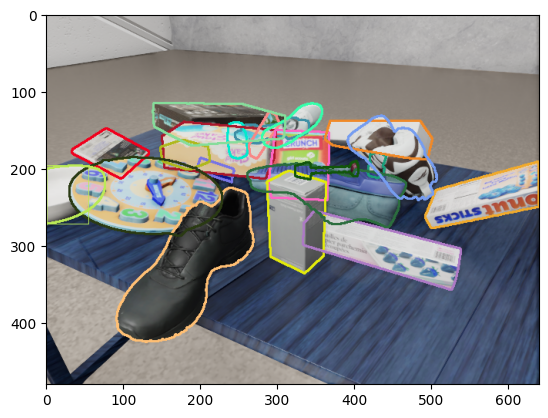

In [17]:
vis_img_list = referenceDict[1]["amodal"]
if len(vis_img_list) > 0:
    vis_img = rgb_img.copy()
    bbox_vis_img = rgb_img.copy()

    # num_colors = np.max(vis_img_list) + 1
    # num_channels = 3
    # color_pixels = random_colours(num_colors, True, num_channels)
    # color_pixels = [[color_pixel[i] * 255 for i in range(num_channels)] for color_pixel in color_pixels]

    color_image = np.zeros(rgb_img.shape, dtype=np.uint8)
    overlay = rgb_img.copy()
    # iterate through all occlusion masks
    for i, visMask in enumerate(vis_img_list):
        visible_mask =  mask_util.decode(visMask)
        # bbox = get_bbox(visible_mask)
        # if referenceDict["category_id"][i] == 0:
        #     vis_img_back = rgb_img.copy()
        #     overlay_back = rgb_img.copy()
        #     visible_mask = visible_mask.astype(bool) # boolean mask
        #     overlay_back[visible_mask] = [0, 0, 255]
            
        #     alpha =0.5                  
        #     vis_img_back = cv2.addWeighted(overlay_back, alpha, vis_img_back, 1 - alpha, 0, vis_img_back)      

        #     vis_save_path = f"{vis_dir_img}/rgb_visible_mask_{id}_background.png"
        #     cv2.imwrite(vis_save_path, vis_img_back)
        # else:
        vis_combined_mask = visible_mask.astype(bool) # boolean mask      
        colour = list(np.random.choice(range(256), size=3))
        overlay[vis_combined_mask] = colour

        # draw bbox
        x, y, w, h = list(map(int, bbox))
        colour = tuple(int(c) for c in colour)
        cv2.rectangle(bbox_vis_img, (x, y), (x + w, y + h), colour , 1)

        def find_contours(mask):
            contours, _ = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
            polygons = []

            for object in contours:
                coords = []
                
                for point in object:
                    coords_point = []
                    coords_point.append(int(point[0][0]))
                    coords_point.append(int(point[0][1]))
                    coords.append(coords_point)
                polygons.append(coords)
            return polygons
            # cv2.rectangle(bbox_vis_img, (x, y), (x + w, y + h), (255,0,0), 1)

            # fill instance segmentation mask
        isClosed = True
 
        # Blue color in BGR
        color = (255, 0, 0)
        
        # Line thickness of 2 px
        thickness = 2
        polygons = find_contours(visible_mask)
        # Using cv2.polylines() method
        for pts in polygons:
            pts = np.array(pts)
            bbox_vis_img = cv2.polylines(bbox_vis_img, [pts],
                                isClosed, colour, thickness)
            


        
    # segmentation_masks = np.zeros((len(vis_img_list), *segmentation_mappings.shape), dtype=np.bool)
    # index_list = []
    # for index, segmentation_id in enumerate(segmentation_list):
    #     segmentation_masks[index] = segmentation_mappings == segmentation_id
    #     index_list.append(segmentation_id)
    # segmentation_masks = np.zero
    # for index, mask, colour in zip(index_list, segmentation_mask, color_pixels):
    #     color_image[mask] = color_pixels[index] if index > 0 else 0
    plt.imshow(bbox_vis_img)

In [2]:
def get_bbox(mask):
    ys, xs = np.where(mask)
    if len(xs) == 0 or len(ys) == 0:
        return [0, 0, 0, 0]
    x_min, x_max = xs.min(), xs.max()
    y_min, y_max = ys.min(), ys.max()
    return [int(x_min), int(y_min), int(x_max-x_min), int(y_max-y_min)]
get_bbox(vis_mask)
x, y, w, h = list(map(int, get_bbox(vis_mask)))
cv2.rectangle(rgb_img, (x, y), (x + w, y + h), (255,0,0), 1)
plt.imshow(rgb_img)

NameError: name 'vis_mask' is not defined

In [31]:
def bbox_from_binary_mask(binary_mask):
    """ Returns the smallest bounding box containing all pixels marked "1" in the given image mask.
    :param binary_mask: A binary image mask with the shape [H, W].
    :return: The bounding box represented as [x, y, width, height]
    """
    # Find all columns and rows that contain 1s
    rows = np.any(binary_mask, axis=1)
    cols = np.any(binary_mask, axis=0)
    # Find the min and max col/row index that contain 1s
    rmin, rmax = np.where(rows)[0][[0, -1]]
    cmin, cmax = np.where(cols)[0][[0, -1]]
    # Calc height and width
    h = rmax - rmin + 1
    w = cmax - cmin + 1
    return [int(cmin), int(rmin), int(w), int(h)]
bbox_from_binary_mask(vis_mask)

[255, 134, 87, 18]

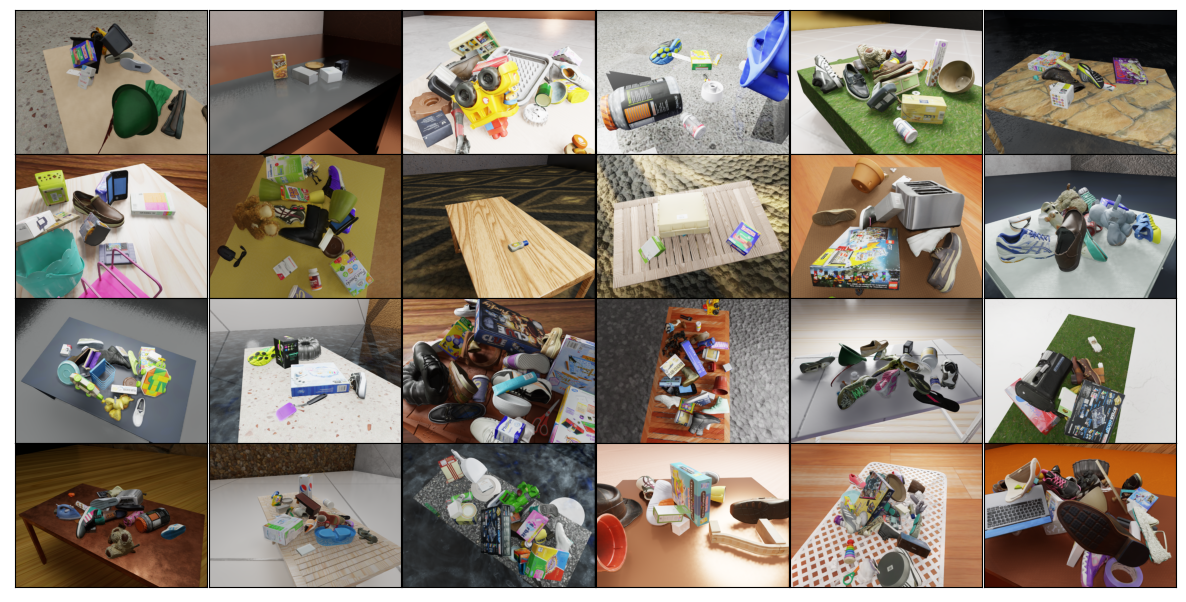

In [101]:
from keras_preprocessing.image import ImageDataGenerator,load_img, img_to_array
import matplotlib.pyplot as plt

def visualize_imgs(img_path_list,labels,dataset_name):
    """Visualize Images from image path list and their respective labels

    Args:
        img_path_list (list): list containing image paths
        labels (list): list of groundtruth labels
        dataset_name (string): train or test set name
    """
    fig = plt.figure(figsize=(15,15))
    for i in range(24):
        if i >= len(img_path_list):
            break
        # plt.subplot(8,10,i+1)
        plt.subplot(8,6,i+1)
        plt.xticks([])
        plt.yticks([])
        img = load_img(img_path_list[i]) #,target_size=(400,400,3)
        img = img_to_array(img)
        img = img/255
        plt.imshow(img)
        # plt.xlabel(labels[i])
    plt.subplots_adjust(wspace=0, hspace=0)
    # plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    if dataset_name:
        plt.suptitle(f"{dataset_name}",y=0.92,fontsize=20)
    plt.axis('off')
    plt.show()
    fig.savefig('syntableteaser.png', bbox_inches='tight',pad_inches=0)
import random
img_dir_path = "/home/ngzhili/uoais/datasets/syntable/train/data/mono/rgb"
valid_img_list = sorted(os.listdir(img_dir_path))
random.shuffle(valid_img_list)
img_path_list = []
for i in valid_img_list:
    img_path_list.append(img_dir_path+ '/'+i)

visualize_imgs(img_path_list,valid_img_list,dataset_name=None)

In [77]:
import random
def random_colours(N, enable_random=True, num_channels=3):
    """
    Generate random colors.
    Generate visually distinct colours by linearly spacing the hue 
    channel in HSV space and then convert to RGB space.
    """
    start = 0
    if enable_random:
        random.seed(10)
        start = random.random()
    hues = [(start + i / N) % 1.0 for i in range(N)]
    colours = [list(colorsys.hsv_to_rgb(h, 0.9, 1.0)) for i, h in enumerate(hues)]
    if num_channels == 4:
        for color in colours:
            color.append(1.0)
    if enable_random:
        random.shuffle(colours)
    return colours

In [2]:
import os, shutil
vis_dir = os.path.join(data_dir,"visualise_dataset")
if os.path.exists(vis_dir): # remove contents if exist
    for filename in os.listdir(vis_dir):
        file_path = os.path.join(vis_dir, filename)
        try:
            if os.path.isfile(file_path) or os.path.islink(file_path):
                os.unlink(file_path)
            elif os.path.isdir(file_path):
                shutil.rmtree(file_path)
        except Exception as e:
            print('Failed to delete %s. Reason: %s' % (file_path, e))
else:
    os.makedirs(vis_dir)

def get_bbox(mask):
    ys, xs = np.where(mask)
    if len(xs) == 0 or len(ys) == 0:
        return [0, 0, 0, 0]
    x_min, x_max = xs.min(), xs.max()
    y_min, y_max = ys.min(), ys.max()
    return [int(x_min), int(y_min), int(x_max-x_min), int(y_max-y_min)]

# query_img_id_list = [1]
query_img_id_list = [i for i in range(1,len(referenceDict)+1)] # visualise all images

for id in query_img_id_list:
    if id in referenceDict:
        
        ann_dic = referenceDict[id]
        vis_dir_img = os.path.join(vis_dir,str(id))
        if not os.path.exists(vis_dir_img):
            os.makedirs(vis_dir_img)
        if not os.path.exists(os.path.join(vis_dir_img,'visible_mask')):
            os.makedirs(os.path.join(vis_dir_img,'visible_mask'))
        if not os.path.exists(os.path.join(vis_dir_img,'amodal_mask')):
            os.makedirs(os.path.join(vis_dir_img,'amodal_mask'))
   
        # mask = mask_util.decode(segm)
        # cv2.imwrite(f"{output_dir}/segmentations/{image_id}_{ann_id}.png", mask*255)

        # segm = ann["visible_mask"] # visible
        # mask = mask_util.decode(segm)
        # cv2.imwrite(f"{output_dir}/visible_masks/{image_id}_{ann_id}.png", mask*255)

        # segm = ann["occluded_mask"] # occluded
        # mask = mask_util.decode(segm)
        # cv2.imwrite(f"{output_dir}/occluded_masks/{image_id}_{ann_id}.png", mask*255)
        # print(ann_dic["rgb"])
        rgb_path = os.path.join(data_dir,ann_dic["rgb"])
        rgb_img = cv2.imread(rgb_path, cv2.IMREAD_UNCHANGED)
        rgb_save_path = f"{vis_dir_img}/rgb_{id}.png"
        cv2.imwrite(rgb_save_path, rgb_img)
        # visualise depth image
        depth_path = os.path.join(data_dir,ann_dic["depth"])
        from PIL import Image
        im = Image.open(depth_path)
        im = np.array(im)
        depth_img = Image.fromarray(normalize_greyscale_image(im.astype("float32")))
        file = os.path.join(vis_dir_img,f"depth_{id}.png")
        depth_img.save(file, "PNG")

        # visualise occlusion masks on rgb image
        occ_img_list = ann_dic["occluded"]
        if len(occ_img_list) > 0:
            occ_img = rgb_img.copy()
            overlay = rgb_img.copy()
            combined_mask = np.zeros((occ_img.shape[0],occ_img.shape[1]))
            # iterate through all occlusion masks
            for i, occMask in enumerate(occ_img_list):
                occluded_mask = mask_util.decode(occMask)
                if ann_dic["category_id"][i] == 0:
                    occ_img_back = rgb_img.copy()
                    overlay_back = rgb_img.copy()
                    occluded_mask = occluded_mask.astype(bool) # boolean mask
                    overlay_back[occluded_mask] = [0, 0, 255]
                    # print(np.unique(occluded_mask))
                    alpha =0.5                  
                    occ_img_back = cv2.addWeighted(overlay_back, alpha, occ_img_back, 1 - alpha, 0, occ_img_back)      

                    occ_save_path = f"{vis_dir_img}/rgb_occlusion_{id}_background.png"
                    cv2.imwrite(occ_save_path, occ_img_back)
                else:
                    combined_mask += occluded_mask

            combined_mask = combined_mask.astype(bool) # boolean mask
            overlay[combined_mask] = [0, 0, 255]
            
            alpha =0.5                  
            occ_img = cv2.addWeighted(overlay, alpha, occ_img, 1 - alpha, 0, occ_img)      

            occ_save_path = f"{vis_dir_img}/rgb_occlusion_{id}.png"
            cv2.imwrite(occ_save_path, occ_img)

            combined_mask = combined_mask.astype('uint8')
            occ_save_path = f"{vis_dir_img}/occlusion_mask_{id}.png"
            cv2.imwrite(occ_save_path, combined_mask*255)


            cols = 4
            rows = len(occ_img_list) // cols + 1
            # print(len(amodal_img_list))
            # print(cols,rows)
            from matplotlib import pyplot as plt
            fig = plt.figure(figsize=(20,10))
            for index, occMask in enumerate(occ_img_list):
                occ_mask = mask_util.decode(occMask)
                plt.subplot(rows,cols, index+1)
                plt.axis('off')
                plt.title(ann_dic["object_name"][index])
                plt.imshow(occ_mask)

            plt.tight_layout()
            plt.suptitle(f"Occlusion Masks for {id}.png")
            # plt.show()        
            plt.savefig(f'{vis_dir_img}/occ_masks_{id}.png')
            plt.close()
        
         #  visualise visible bbox on rgb image
        # bbox_img_list = ann_dic["bbox"]
        # if len(vis_img_list) > 0:
        #     vis_img = rgb_img.copy()
        #     # overlay = rgb_img.copy()
        #     # iterate through all visible bbox
        #     fig = plt.figure(figsize=(20,10))
        #     for i, bbox in enumerate(bbox_img_list):
        #         if ann_dic["category_id"][i] == 0:
        #             pass
        #         else:

        #             x, y, w, h = list(map(int, bbox))

        #             cv2.rectangle(vis_img, (x, y), (x + w, y + h), (255,0,0), 4)

           
        #     # alpha = 0.5   
        #     # vis_img = cv2.addWeighted(overlay, alpha, vis_img, 1 - alpha, 0, vis_img)        
        #     vis_save_path = f"{vis_dir_img}/rgb_visible_bbox_{id}.png"
        #     cv2.imwrite(vis_save_path,vis_img)
        #     plt.imshow(vis_img)
        #     # plt.close()
        #     # cols = 4
        #     # rows = len(vis_img_list) // cols + 1
        #     # # print(len(amodal_img_list))
        #     # # print(cols,rows)
        #     # from matplotlib import pyplot as plt
        #     # fig = plt.figure(figsize=(20,10))
        #     # for index, visMask in enumerate(vis_img_list):
        #     #     vis_mask = mask_util.decode(visMask)
        #     #     plt.subplot(rows,cols, index+1)
        #     #     plt.axis('off')
            #     plt.title(ann_dic["object_name"][index])
            #     plt.imshow(vis_mask)

            # plt.tight_layout()
            # plt.suptitle(f"Visible Bounding Box for {id}.png")
            # # plt.show()        
            # plt.savefig(f'{vis_dir_img}/visible_bbox_{id}.png')
            # plt.close()

        #  visualise visible masks on rgb image
        vis_img_list = ann_dic["visible"]
        amodal_img_list =ann_dic["amodal"]
        if len(vis_img_list) > 0:
            vis_img = rgb_img.copy()
            bbox_vis_img = rgb_img.copy()
            amodal_boundary_img = rgb_img.copy()
            occ_boundary_img = rgb_img.copy()

            # num_colors = np.max(vis_img_list) + 1
            # num_channels = 3
            # color_pixels = random_colours(num_colors, True, num_channels)
            # color_pixels = [[color_pixel[i] * 255 for i in range(num_channels)] for color_pixel in color_pixels]

            color_image = np.zeros(rgb_img.shape, dtype=np.uint8)
            overlay = rgb_img.copy()

            # Create empty color image
            vis_color_mask = np.zeros((rgb_img.shape[0], rgb_img.shape[1], 3), dtype=np.uint8)

            colour_list = []
            for _ in range(len(vis_img_list)):
                colour = list(np.random.choice(range(256), size=3))
                colour_list.append(colour)

            # iterate through all occlusion masks
            for i, visMask in enumerate(vis_img_list):
                amodal_mask = mask_util.decode(amodal_img_list[i])
                visible_mask =  mask_util.decode(visMask)
                occlusion_mask = mask_util.decode(occ_img_list[i])
                bbox = get_bbox(visible_mask)
                # background
                if ann_dic["category_id"][i] == 0:
                    vis_img_back = rgb_img.copy()
                    overlay_back = rgb_img.copy()
                    visible_mask = visible_mask.astype(bool) # boolean mask
                    overlay_back[visible_mask] = [0, 0, 255]
                    
                    alpha =0.5                  
                    vis_img_back = cv2.addWeighted(overlay_back, alpha, vis_img_back, 1 - alpha, 0, vis_img_back)      

                    vis_save_path = f"{vis_dir_img}/rgb_visible_mask_{id}_background.png"
                    cv2.imwrite(vis_save_path, vis_img_back)
                # any object
                else:
                    vis_combined_mask = visible_mask.astype(bool) # boolean mask      
                    # colour = list(np.random.choice(range(256), size=3))
                    overlay[vis_combined_mask] = colour_list[i]

                    # draw bbox
                    x, y, w, h = list(map(int, bbox))
                    colour_tuple = tuple(int(c) for c in colour_list[i])
                    # draw bbox rectangle
                    cv2.rectangle(bbox_vis_img, (x, y), (x + w, y + h), colour_tuple , 2)

                    obj_id = str(i)
                    # Finds space required by the text so that we can put a background with that amount of width.
                    (w_text, h1), _ = cv2.getTextSize(obj_id, cv2.FONT_HERSHEY_SIMPLEX, 0.4, 1)

                    # Prints the text.    
                    bbox_vis_img = cv2.rectangle(bbox_vis_img, (x, y - 16), (x + w_text, y), colour_tuple, -1)
                    bbox_vis_img = cv2.putText(bbox_vis_img, obj_id, (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255,255,255), 1)
                    # cv2.putText(bbox_vis_img, obj_id, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0,0,0), 2)
                    # cv2.rectangle(bbox_vis_img, (x, y), (x + w, y + h), (255,0,0), 1)

                    # fill instance segmentation mask
                    def find_contours(mask):
                        contours, _ = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
                        polygons = []

                        for object in contours:
                            coords = []
                            
                            for point in object:
                                coords_point = []
                                coords_point.append(int(point[0][0]))
                                coords_point.append(int(point[0][1]))
                                coords.append(coords_point)
                            polygons.append(coords)
                        return polygons
                        # cv2.rectangle(bbox_vis_img, (x, y), (x + w, y + h), (255,0,0), 1)

                    # draw amodal polygons
                    polygons = find_contours(amodal_mask)
                    # Using cv2.polylines() method
                    for pts in polygons:
                        pts = np.array(pts)
                        amodal_boundary_img = cv2.polylines(amodal_boundary_img, [pts],
                                            isClosed = True, color=colour_tuple, thickness=2)
                    # draw occlusion polygons
                    occ_polygons = find_contours(occlusion_mask)
                    # Using cv2.polylines() method
                    for pts in occ_polygons:
                        pts = np.array(pts)
                        occ_boundary_img = cv2.polylines(occ_boundary_img, [pts],
                                            isClosed = True, color=colour_tuple, thickness=2)
                    
                    # Assign color to combined colour mask
                    vis_color_mask[visible_mask > 0] = colour_list[i] #(255, 0, 0)  # Blue color for mask pixels

                    # save instance colour mask
                    color_mask_instance = np.zeros((rgb_img.shape[0], rgb_img.shape[1], 3), dtype=np.uint8)
                    color_mask_instance[visible_mask > 0] = colour_list[i]
                    vis_instance_save_path = f"{vis_dir_img}/visible_mask/visible_mask_{id}_{i}.png"
                    cv2.imwrite(vis_instance_save_path,color_mask_instance)

                    amodal_color_mask_instance = np.zeros((rgb_img.shape[0], rgb_img.shape[1], 3), dtype=np.uint8)
                    amodal_color_mask_instance[amodal_mask > 0] = colour_list[i]
                    amodal_instance_save_path = f"{vis_dir_img}/amodal_mask/amodal_mask_{id}_{i}.png"
                    cv2.imwrite(amodal_instance_save_path,amodal_color_mask_instance)
                    
                    # plt.imshow(amodal_boundary_img)
            # # segmentation_masks = np.zeros((len(vis_img_list), *segmentation_mappings.shape), dtype=np.bool)
            # index_list = []
            # for index, segmentation_id in enumerate(segmentation_list):
            #     segmentation_masks[index] = segmentation_mappings == segmentation_id
            #     index_list.append(segmentation_id)
            # segmentation_masks = np.zero
            # for index, mask, colour in zip(index_list, segmentation_mask, color_pixels):
            #     color_image[mask] = color_pixels[index] if index > 0 else 0

            alpha = 0.5   
            vis_img = cv2.addWeighted(overlay, alpha, vis_img, 1 - alpha, 0, vis_img)        
            vis_save_path = f"{vis_dir_img}/rgb_visible_mask_{id}.png"
            cv2.imwrite(vis_save_path,vis_img)

            vis_bbox_save_path = f"{vis_dir_img}/rgb_visible_bbox_{id}.png"
            cv2.imwrite(vis_bbox_save_path, bbox_vis_img)
            # plt.imshow(bbox_vis_img)
            # plt.show()
            amodal_save_path = f"{vis_dir_img}/rgb_amodal_contour_{id}.png"
            cv2.imwrite(amodal_save_path,amodal_boundary_img)

            occlusion_save_path = f"{vis_dir_img}/rgb_occlusion_contour_{id}.png"
            cv2.imwrite(occlusion_save_path,occ_boundary_img)

            alpha = 0.5   
            vis_mask_occ_boundary_img = cv2.addWeighted(overlay, alpha, occ_boundary_img, 1 - alpha, 0, vis_img)        
            vis_mask_occ_boundary_save_path = f"{vis_dir_img}/rgb_visible_mask_occlusion_boundary_{id}.png"
            cv2.imwrite(vis_mask_occ_boundary_save_path,vis_mask_occ_boundary_img)


            vis_segmentation_save_path = f"{vis_dir_img}/visible_mask/visible_mask_{id}_{i}.png"
            cv2.imwrite(vis_segmentation_save_path,color_mask_instance)

            cols = 4
            rows = len(vis_img_list) // cols + 1
            # print(len(amodal_img_list))
            # print(cols,rows)
            from matplotlib import pyplot as plt
            fig = plt.figure(figsize=(20,10))
            for index, visMask in enumerate(vis_img_list):
                vis_mask = mask_util.decode(visMask)
                plt.subplot(rows,cols, index+1)
                plt.axis('off')
                plt.title(ann_dic["object_name"][index])
                plt.imshow(vis_mask)

            plt.tight_layout()
            plt.suptitle(f"Visible Masks for {id}.png")
            # plt.show()        
            plt.savefig(f'{vis_dir_img}/vis_masks_{id}.png')
            plt.close()

        # visualise amodal masks
        # img_dir_path = f"{output_dir}/visualize_occlusion_masks/"
        # img_list = sorted(os.listdir(img_dir_path), key=lambda x: float(x[4:-4]))
        amodal_img_list = ann_dic["amodal"]
        if len(amodal_img_list) > 0:
            cols = 4
            rows = len(amodal_img_list) // cols + 1
            # print(len(amodal_img_list))
            # print(cols,rows)
            from matplotlib import pyplot as plt
            fig = plt.figure(figsize=(20,10))
            for index, amoMask in enumerate(amodal_img_list):
                amodal_mask = mask_util.decode(amoMask)
                plt.subplot(rows,cols, index+1)
                plt.axis('off')
                plt.title(ann_dic["object_name"][index])
                plt.imshow(amodal_mask)

            plt.tight_layout()
            plt.suptitle(f"Amodal Masks for {id}.png")
            # plt.show()        
            plt.savefig(f'{vis_dir_img}/amodal_masks_{id}.png')
            plt.close()







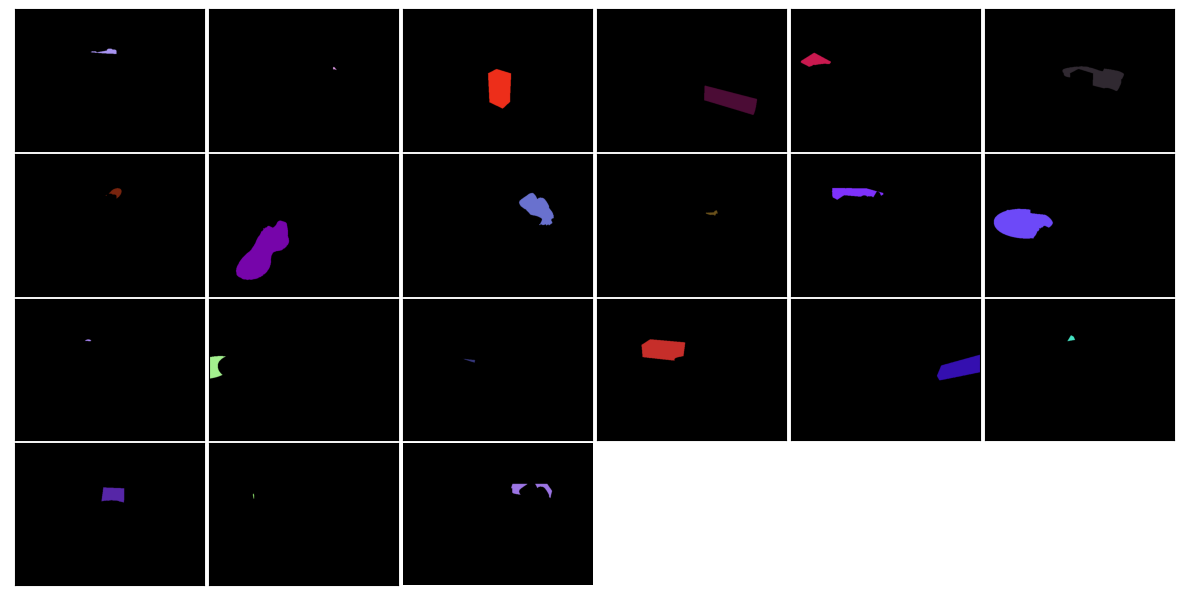

In [31]:
from keras_preprocessing.image import ImageDataGenerator,load_img, img_to_array
import matplotlib.pyplot as plt

def visualize_imgs(img_path_list,labels,dataset_name):
    """Visualize Images from image path list and their respective labels

    Args:
        img_path_list (list): list containing image paths
        labels (list): list of groundtruth labels
        dataset_name (string): train or test set name
    """
    fig = plt.figure(figsize=(15,15))
    for i in range(24):
        if i >= len(img_path_list):
            break
        # plt.subplot(8,10,i+1)
        plt.subplot(8,6,i+1)
        plt.xticks([])
        plt.yticks([])
        img = load_img(img_path_list[i]) #,target_size=(400,400,3)
        img = img_to_array(img)
        img = img/255
        plt.imshow(img)
        # plt.xlabel(labels[i])
    plt.subplots_adjust(wspace=0.01, hspace=0.02)
    # plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    if dataset_name:
        plt.suptitle(f"{dataset_name}",y=0.92,fontsize=20)
    plt.axis('off')
    plt.show()
    # fig.savefig('syntableteaser.png', bbox_inches='tight',pad_inches=0)
import random
img_dir_path = "/home/ngzhili/uoais/datasets/syntable/train/visualise_dataset/1/visible_mask"
valid_img_list = sorted(os.listdir(img_dir_path))
# random.shuffle(valid_img_list)
img_path_list = []
for i in valid_img_list:
    img_path_list.append(img_dir_path+ '/'+i)

visualize_imgs(img_path_list,valid_img_list,dataset_name=None)


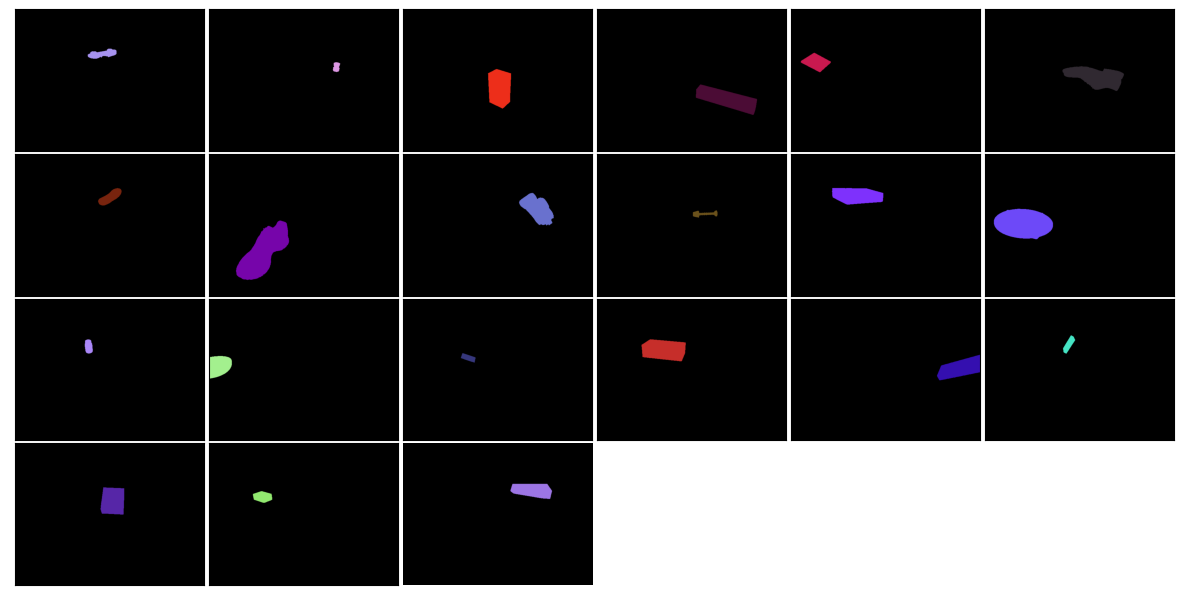

In [32]:
import random
img_dir_path = "/home/ngzhili/uoais/datasets/syntable/train/visualise_dataset/1/amodal_mask"
valid_img_list = sorted(os.listdir(img_dir_path))
# random.shuffle(valid_img_list)
img_path_list = []
for i in valid_img_list:
    img_path_list.append(img_dir_path+ '/'+i)

visualize_imgs(img_path_list,valid_img_list,dataset_name=None)

## Visualise Object Masks

In [12]:
len(referenceDict)

5

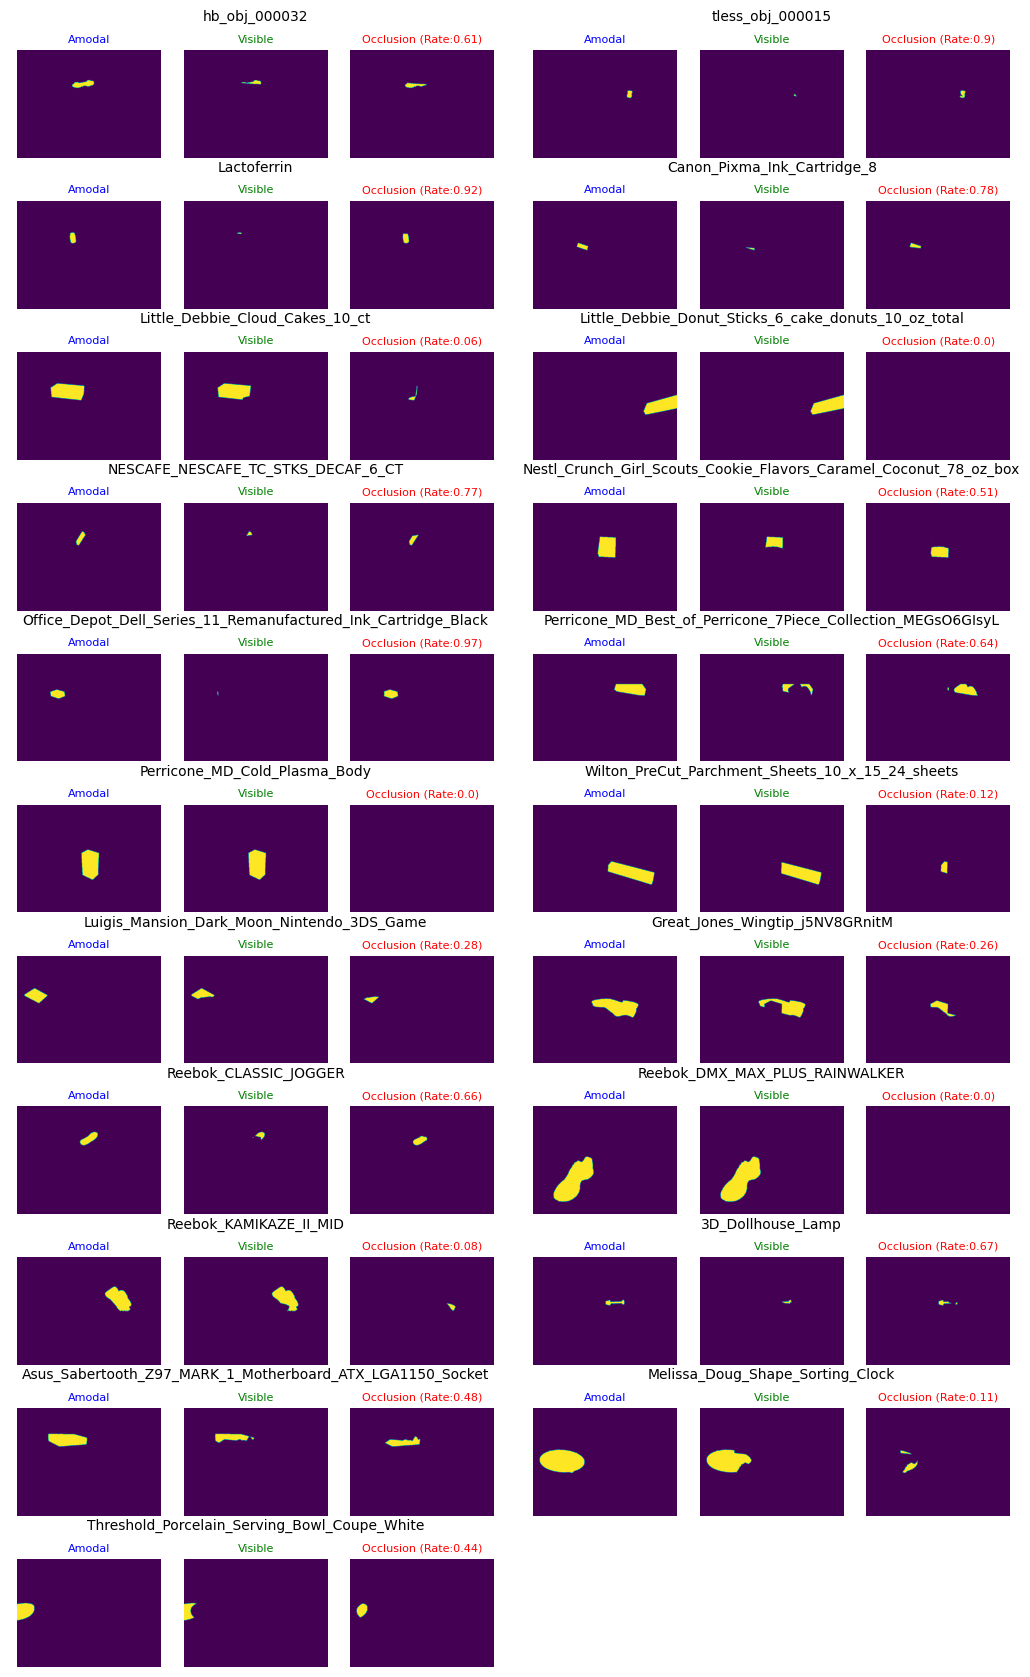

In [11]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec


query_img_id_list = [i for i in range(1,len(referenceDict)+1)]
query_img_id_list = [1]
# data_dir = "/home/knowledge/zhili/dataset/scenario_room"
# data_dir = "/home/knowledge/zhili/dataset/test_room"
# vis_dir = "visualise_dataset"

for id in query_img_id_list:
    if id in referenceDict:
        
        ann_dic = referenceDict[id]
        amodal_img_list = ann_dic["amodal"]
        vis_dir_img = os.path.join(vis_dir,str(id))
        if not os.path.exists(vis_dir_img):
            os.makedirs(vis_dir_img)
            
        # fig = plt.figure(figsize=(15, len(ann_dic["amodal"])//2))
        fig = plt.figure(figsize=(13, len(ann_dic["amodal"])))
        # fig = plt.figure(figsize=(5, 10))
        # fig.suptitle(f"Image {id} - Object Masks Visualisation",verticalalignment='top',y=-1.0)

        outer = gridspec.GridSpec(len(amodal_img_list)//2 +1, 2, wspace=0.05, hspace=0.4)

        for i in range(len(ann_dic["amodal"])):
            object_name = ann_dic["object_name"][i]
            occlusion_rate = ann_dic["occluded_rate"][i]
            inner = gridspec.GridSpecFromSubplotSpec(1, 3,
                            subplot_spec=outer[i], wspace=0.05 )#, wspace=0.1, hspace=0.1)
            # set outer titles
            ax = plt.Subplot(fig, outer[i])
            ax.set_title(object_name, y=1.2, fontsize=10)
            ax.axis('off')
            fig.add_subplot(ax)

            # retrieve masks
            amoMask = ann_dic["amodal"][i]
            amodal_mask = mask_util.decode(amoMask)
            visMask = ann_dic["visible"][i]
            vis_mask = mask_util.decode(visMask)
            occMask = ann_dic["occluded"][i]
            occ_mask = mask_util.decode(occMask)

            for j in range(3):
                ax = plt.Subplot(fig, inner[j])
                # t = ax.text(0.5,0.5, 'outer=%d, inner=%d' % (i, j))
                # t.set_ha('center')
                # ax.set_xticks([])
                # ax.set_yticks([])
                ax.axis('off')
                if j == 0:
                    ax.imshow(amodal_mask)
                    ax.set_title("Amodal", fontsize=8, color='blue')
                elif j == 1:
                    ax.imshow(vis_mask)
                    ax.set_title("Visible", fontsize=8, color='green')
                elif j == 2:
                    ax.imshow(occ_mask)
                    ax.set_title(f"Occlusion (Rate:{occlusion_rate})", fontsize=8, color='red')       
                fig.add_subplot(ax)

        # fig.suptitle(f"Image {id} - Object Masks Visualisation",verticalalignment='top')
        # fig.show()

        # fig.tight_layout()
        # plt.imshow(fig)
        # fig.savefig(f'{vis_dir_img}/object_masks_{id}.png', bbox_inches = 'tight') # , pad_inches = 0.1)
        # plt.close()
        fig.show()

Calculating Directed Graph for Scene:1
Nodes: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
Edges: [(1, 12), (3, 12), (3, 13), (5, 4), (6, 7), (8, 2), (9, 3), (9, 10), (11, 6), (11, 7), (11, 8), (11, 9), (13, 1), (13, 12), (14, 3)]
start_nodes: [5, 11, 14]
end_nodes: [2, 4, 7, 10, 12]
intermediate_nodes: [1, 3, 6, 8, 9, 13]
(Degree of clustering) Number of Weakly Connected Components: 2
(Scene Complexity/Degree of overlapping regions) Sizes of Weakly Connected Components: [12, 2]
(Minimum no. of depth layers to order all regions in WCC) Longest directed path of Weakly Connected Components: 5
Is Directed Acyclic Graph (DAG)?: True


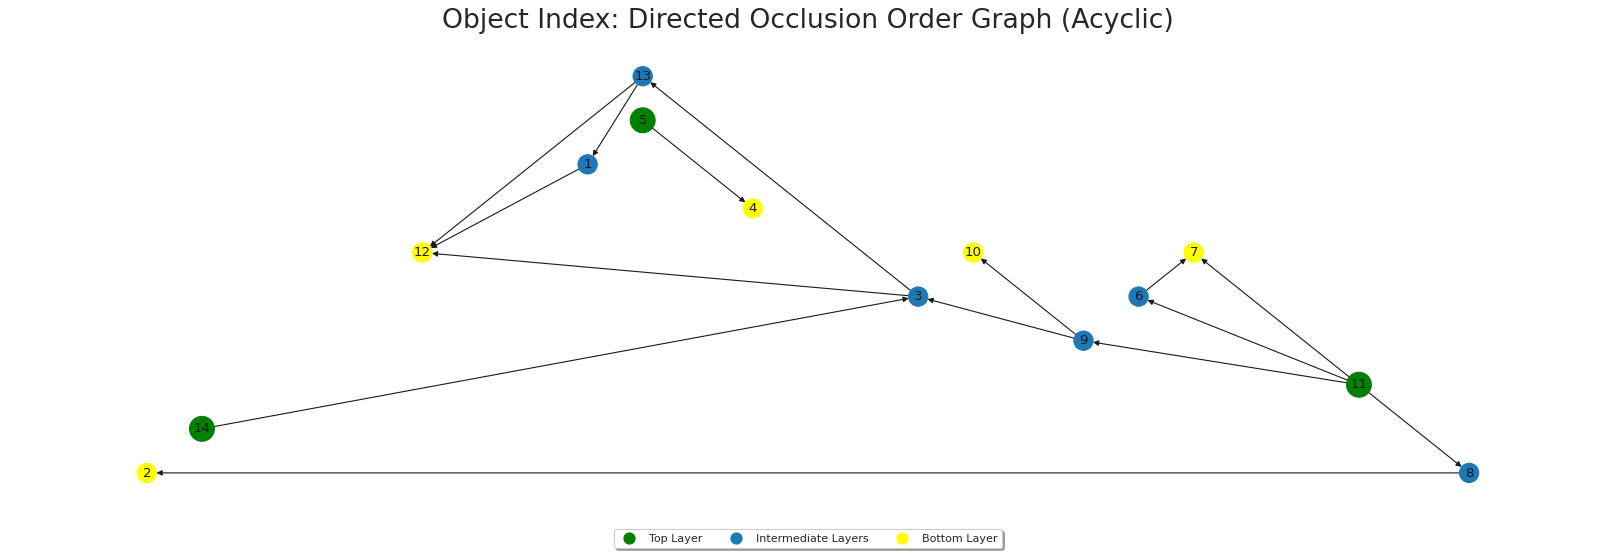

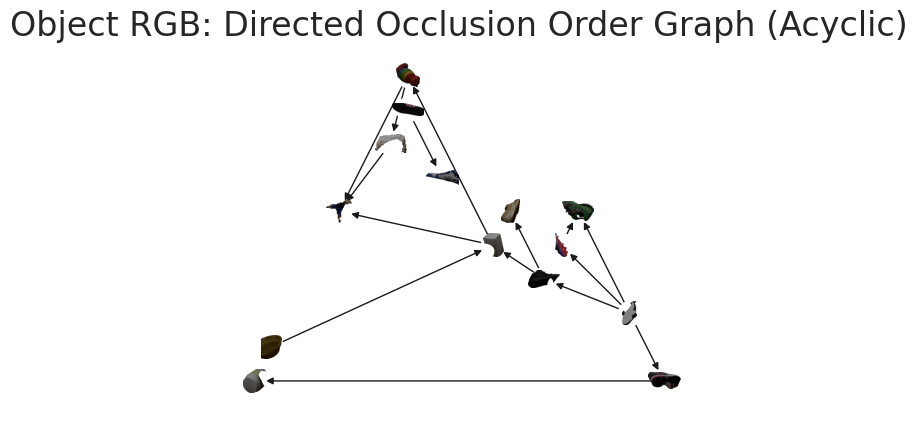

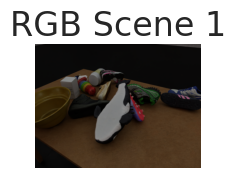

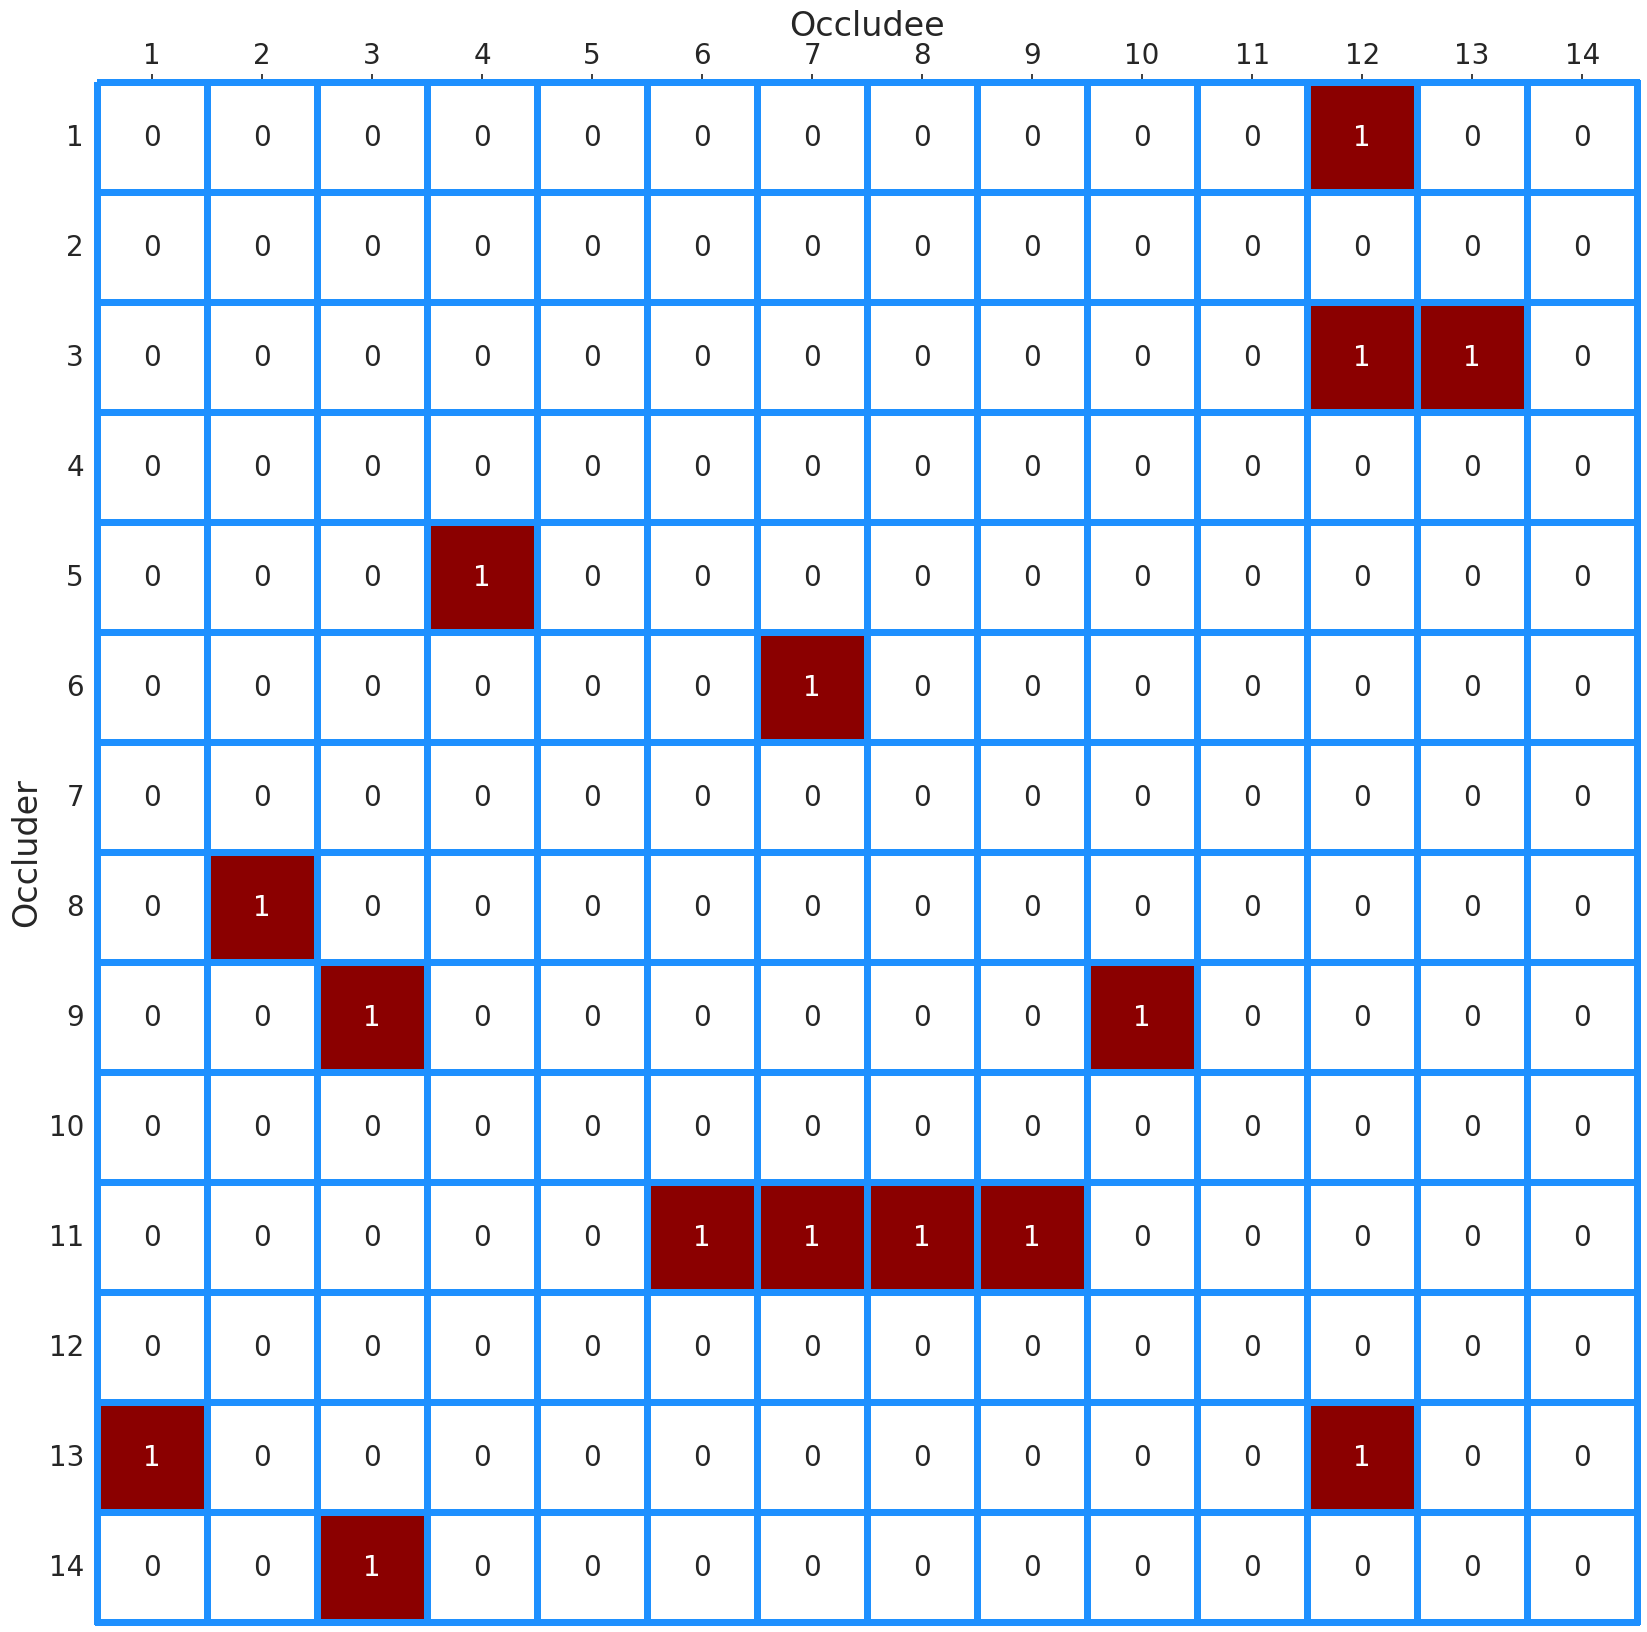

Calculating Directed Graph for Scene:8
Nodes: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Edges: [(1, 7), (2, 7), (3, 6), (5, 4), (6, 2), (6, 9), (9, 3), (10, 8)]
start_nodes: [1, 5, 10]
end_nodes: [4, 7, 8]
intermediate_nodes: [2, 3, 6, 9]
(Degree of clustering) Number of Weakly Connected Components: 3
(Scene Complexity/Degree of overlapping regions) Sizes of Weakly Connected Components: [6, 2, 2]
Graph is not directed and contains a cycle!
Is Directed Acyclic Graph (DAG)?: False


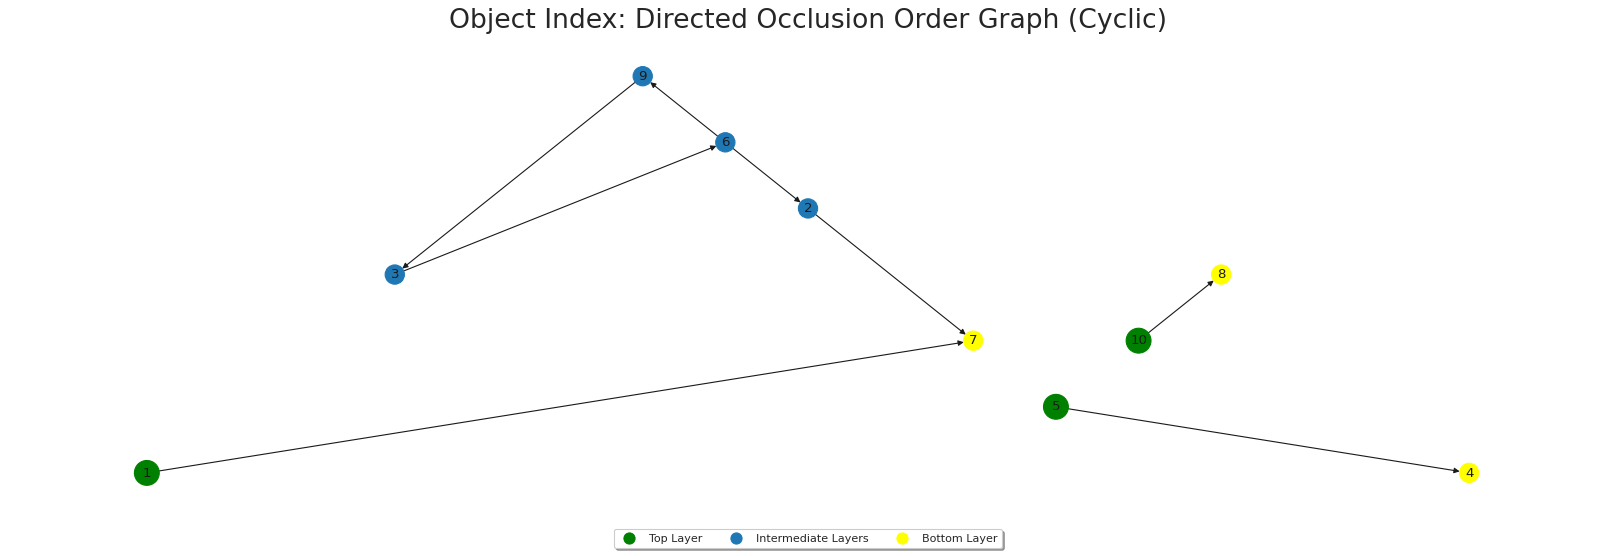

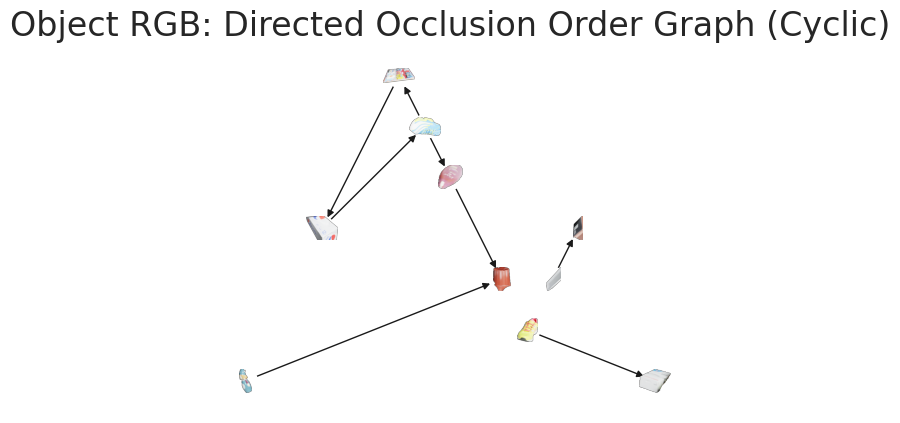

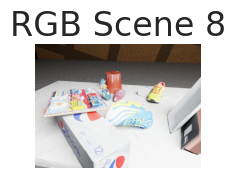

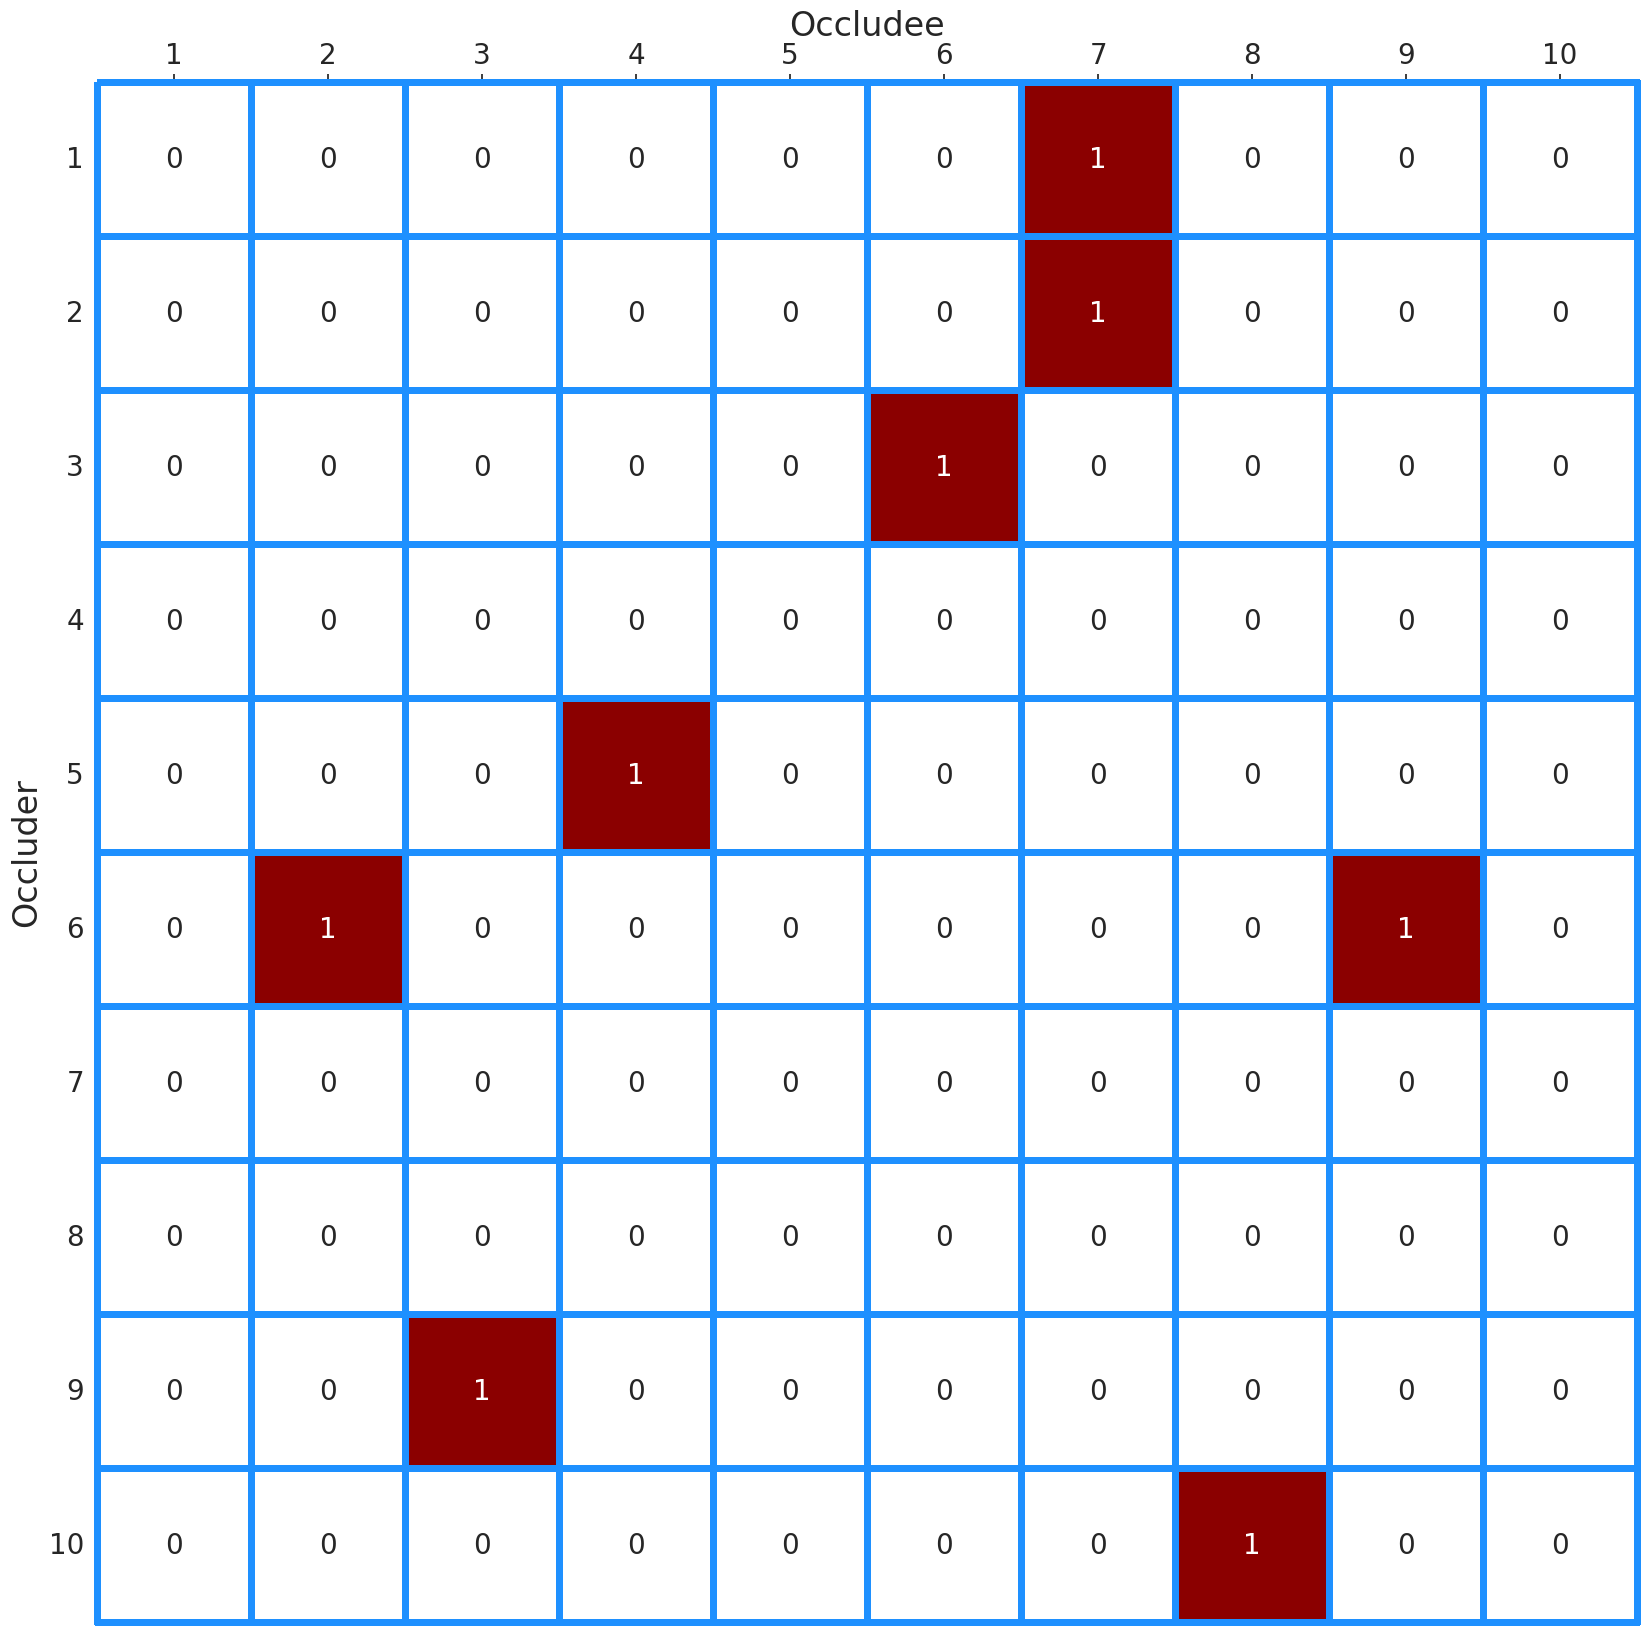

Calculating Directed Graph for Scene:9
Nodes: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Edges: [(2, 7), (5, 4), (6, 3), (9, 3), (10, 8)]
start_nodes: [1, 2, 5, 6, 9, 10]
end_nodes: [3, 4, 7, 8]
intermediate_nodes: []
(Degree of clustering) Number of Weakly Connected Components: 5
(Scene Complexity/Degree of overlapping regions) Sizes of Weakly Connected Components: [1, 2, 3, 2, 2]
(Minimum no. of depth layers to order all regions in WCC) Longest directed path of Weakly Connected Components: 1
Is Directed Acyclic Graph (DAG)?: True


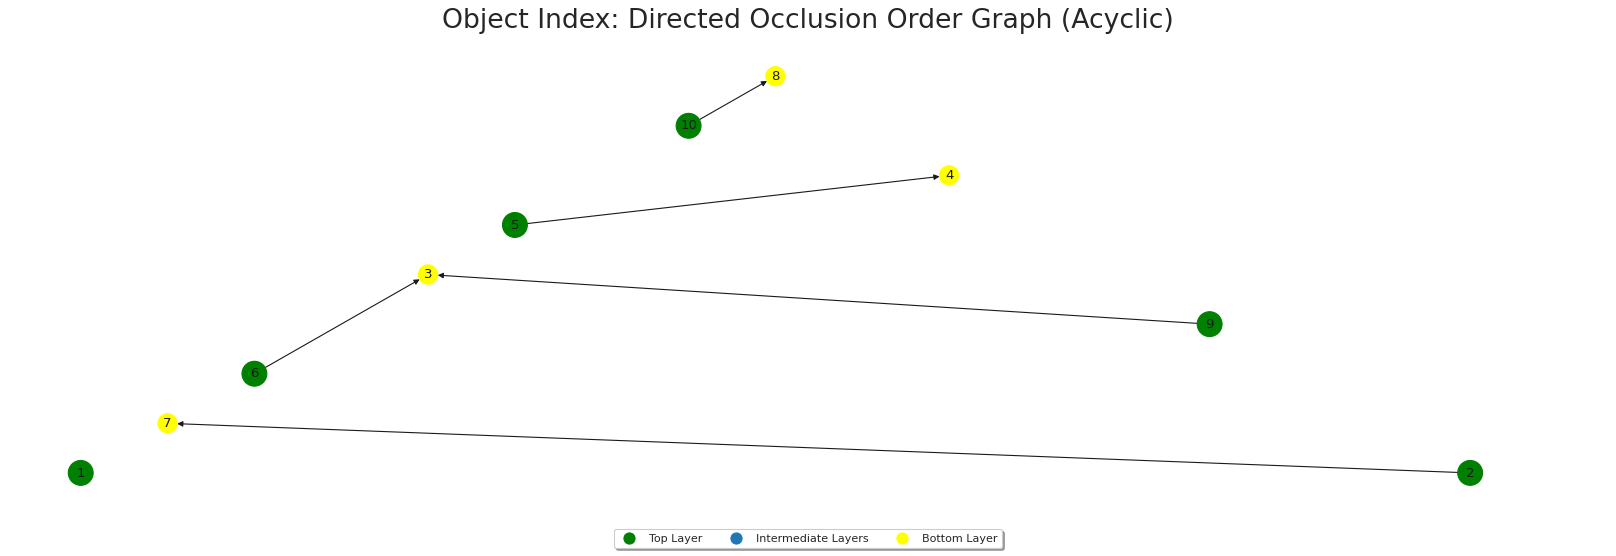

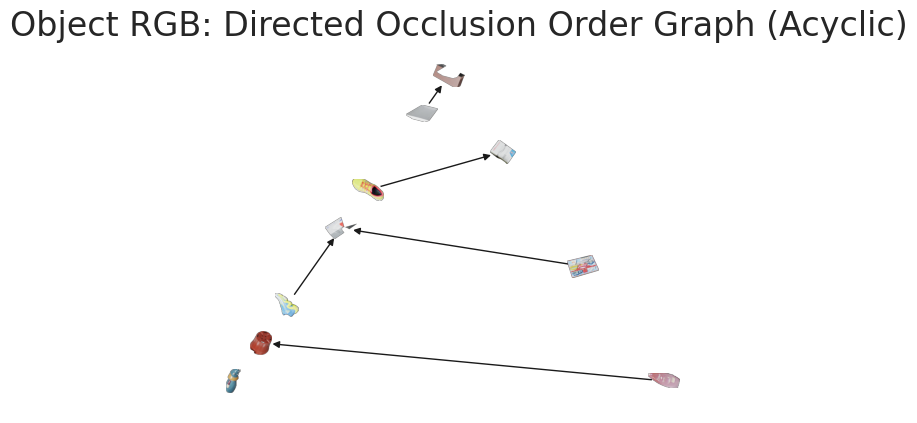

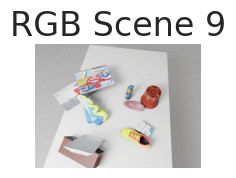

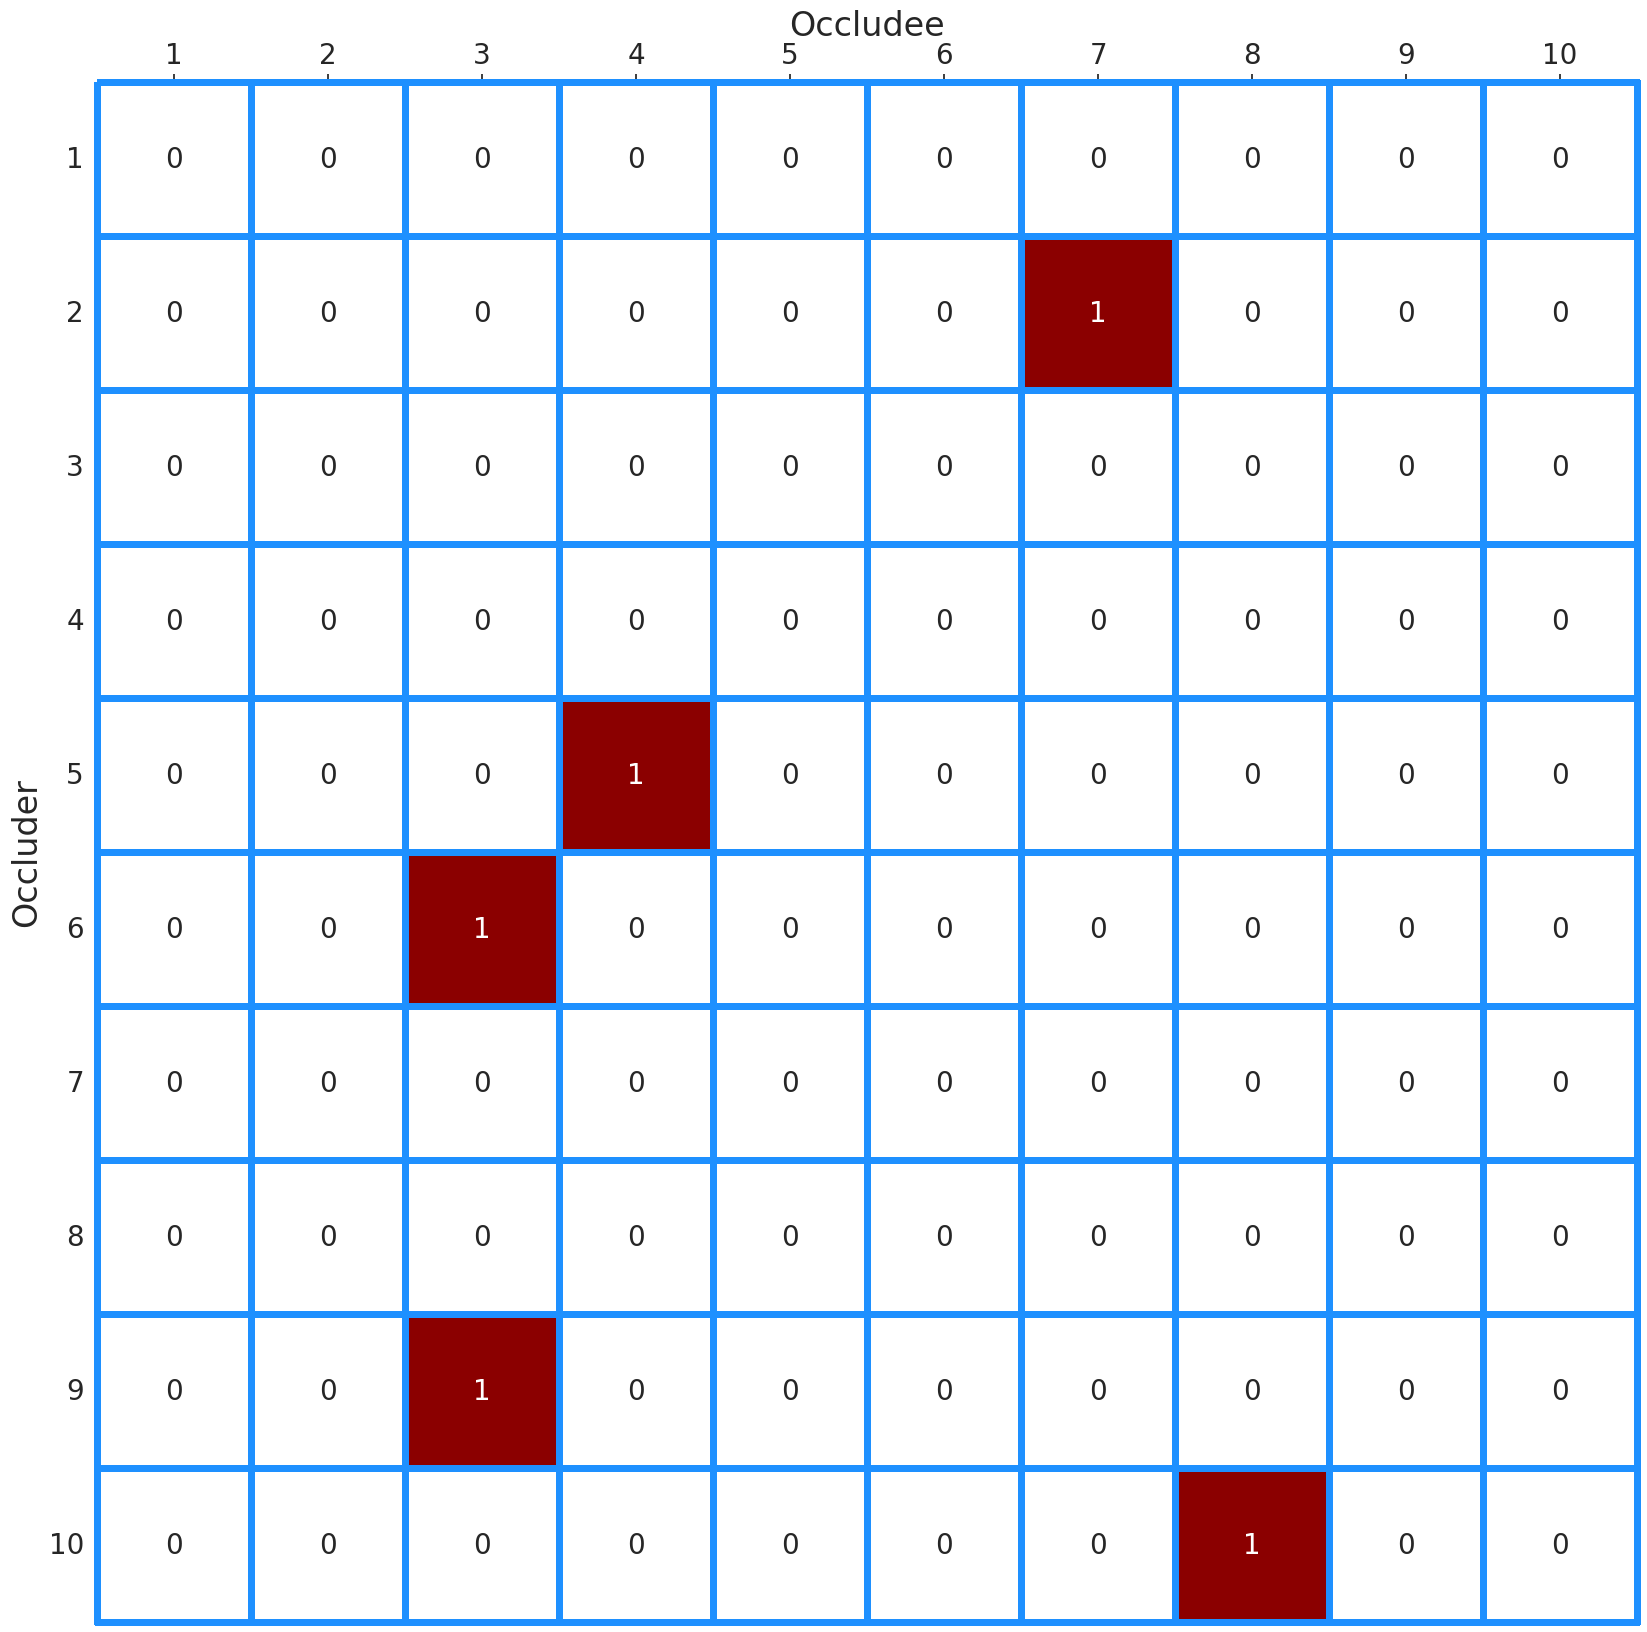

In [8]:
# visualize annotations
import glob
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
from PIL import Image

import matplotlib.pyplot as plt
import networkx as nx
# def show_graph_with_labels(adjacency_matrix,ax):
    
#     labels = [i for i in range(1,len(adjacency_matrix)+1)]
#     labels_dict = {}
#     for i in range(len(adjacency_matrix)):
#         labels_dict.update({i:labels[i]})
    
#     rows, cols = np.where(adjacency_matrix == 1)
#     rows += 1
#     cols += 1
#     edges = zip(rows.tolist(), cols.tolist())
    
#     nodes_list = [i for i in range(1, len(adjacency_matrix)+1)]
#     # G = nx.Graph(directed=True)
#     G = nx.DiGraph()

#     G.add_nodes_from(nodes_list)
#     G.add_edges_from(edges)

#     print("Nodes:",G.nodes())
#     print("Edges:",G.edges())
#     # print(G.in_edges())
#     # print(G.out_edges())
#     # get start nodes
#     start_nodes = [node for (node,degree) in G.in_degree if degree == 0]
#     print("start_nodes:",start_nodes)

#     # get end nodes
#     end_nodes = [node for (node,degree) in G.out_degree if degree == 0]
#     for node in end_nodes:
#         if node in start_nodes:
#             end_nodes.remove(node)
#     print("end_nodes:",end_nodes)

#     # get intermediate notes
#     intermediate_nodes = [i for i in nodes_list if i not in (start_nodes) and i not in (end_nodes)]
#     print("intermediate_nodes:",intermediate_nodes)

#     # nx.draw(gr, node_size=500, with_labels=True)
#     node_color_list = []
#     node_size_list = []
#     for node in nodes_list:
#         if node in start_nodes:
#             node_color_list.append('green')
#             node_size_list.append(500)
#         elif node in end_nodes:
#             node_color_list.append('yellow')
#             node_size_list.append(300)
#         else:
#             node_color_list.append('#1f78b4')
#             node_size_list.append(300)

#     options = {
#     'node_color': node_color_list,
#     'node_size': node_size_list,
#     'width': 2,
#     'arrowstyle': '-|>',
#     'arrowsize': 5
#     }
#     # nx.draw_networkx(G, arrows=True, **options)
#     # nx.draw(G,  with_labels = True,arrows=True, connectionstyle='arc3, rad = 0.1')
#     # nx.draw_spring(G,  labels=labels_dict, with_labels = True,arrows=True, connectionstyle='arc3, rad = 0.5')
#     nx.draw_planar(G,  with_labels = True, arrows=True, **options, ax = ax)
#     dag = nx.is_directed_acyclic_graph(G)
#     print(f"Is Graph Direct Acyclic?: {dag}")

#     import matplotlib.patches as mpatches
#     import matplotlib.pyplot as plt
#     colors = ["green", "#1f78b4", "yellow"]
#     texts = ["Start Nodes", "Intermediate Nodes", "End Nodes"]
#     patches = [ plt.plot([],[], marker="o", ms=10, ls="", mec=None, color=colors[i], 
#                 label="{:s}".format(texts[i]) )[0]  for i in range(len(texts)) ]
#     plt.legend(handles=patches, bbox_to_anchor=(0.5, -0.05), 
#             loc='center', ncol=3, fancybox=True, shadow=True, facecolor="w", numpoints=1 )

#     plt.title("Directed Overlap Order Graph")

def apply_mask(image, mask):
    # Convert to numpy arrays
    image = np.array(image)
    mask = np.array(mask)
    # Convert grayscale image to RGB
    mask = np.stack((mask,)*3, axis=-1)
    # Multiply arrays
    rgb_result= image*mask

    # First create the image with alpha channel
    rgba = cv2.cvtColor(rgb_result, cv2.COLOR_RGB2RGBA)

    # Then assign the mask to the last channel of the image
    # rgba[:, :, 3] = alpha_data
    # Make image transparent white anywhere it is transparent
    rgba[rgba[...,-1]==0] = [255,255,255,0]

    return rgba

def compute_occluded_masks(mask1, mask2):
    """Computes occlusions between two sets of masks.
    masks1, masks2: [Height, Width, instances]
    """

    # If either set of masks is empty return empty result
    #if masks1.shape[-1] == 0 or masks2.shape[-1] == 0:
        #return np.zeros((masks1.shape[-1], masks2.shape[-1]))
    # flatten masks and compute their areas
    #masks1 = np.reshape(masks1 > .5, (-1, masks1.shape[-1])).astype(np.float32)
    #masks2 = np.reshape(masks2 > .5, (-1, masks2.shape[-1])).astype(np.float32)
    #area1 = np.sum(masks1, axis=0)
    #area2 = np.sum(masks2, axis=0)

    # intersections and union
    #intersections_mask = np.dot(masks1.T, masks2)
    mask1_area = np.count_nonzero( mask1 )
    mask2_area = np.count_nonzero( mask2 )
    intersection_mask = np.logical_and( mask1, mask2 )
    intersection = np.count_nonzero( np.logical_and( mask1, mask2 ) )
    iou = intersection/(mask1_area+mask2_area-intersection)

    return iou, intersection_mask.astype(float)

def convert_png(image):
    image = Image.fromarray(np.uint8(image))
    image = image.convert('RGBA')
    # Transparency
    newImage = []
    for item in image.getdata():
        if item[:3] == (0, 0, 0):
            newImage.append((0, 0, 0, 0))
        else:
            newImage.append(item)
    image.putdata(newImage)
    return image

output_dir = "isaac_sim_others/dataset/testing1"
rgb_dir = f"{output_dir}/data/mono/rgb"
occ_dir = f"{output_dir}/data/mono/occlusion"
vis_dir = f"{output_dir}/data/mono/instance"
amodal_dir = f"{output_dir}/data/mono/amodal"

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec


query_img_id_list = [i for i in range(1,len(referenceDict)+1)]
query_img_id_list = [1,8,9]
# data_dir = "/home/knowledge/zhili/dataset/scenario_room"
# data_dir = "/home/knowledge/zhili/dataset/test_room"
# vis_dir = "visualise_dataset"

for scene_index in query_img_id_list:
    if scene_index in referenceDict:
        ann_dic = referenceDict[scene_index]
        vis_dir_img = os.path.join(vis_dir,str(scene_index))
        if not os.path.exists(vis_dir_img):
            os.makedirs(vis_dir_img)
        
        # get rgb_path
        rgb_path = os.path.join(data_dir,ann_dic["rgb"])
        rgb_img = cv2.imread(rgb_path, cv2.IMREAD_UNCHANGED)
        rgb_img = rgb_img[...,::-1]
        # get occlusion order adjacency matrix
        npy_path = os.path.join(data_dir,ann_dic["occlusion_order"])
        occlusion_order_adjacency_matrix = np.load(npy_path)

        print(f"Calculating Directed Graph for Scene:{scene_index}")
        # vis_img = cv2.imread(f"{vis_dir}/visuals/{scene_index}.png", cv2.IMREAD_UNCHANGED)
        rows = cols = len(ann_dic["visible"]) # number of objects
        obj_rgb_mask_list = []
        for i in range(1,len(ann_dic["visible"])+1):
            visMask = ann_dic["visible"][i-1]
            visible_mask = mask_util.decode(visMask)
            
            rgb_crop = apply_mask(rgb_img, visible_mask)
            rgb_crop = convert_png(rgb_crop)
            
            def bbox(im):
                a = np.array(im)[:,:,:3]  # keep RGB only
                m = np.any(a != [0,0,0], axis=2)
                coords = np.argwhere(m)
                y0, x0, y1, x1 = *np.min(coords, axis=0), *np.max(coords, axis=0)
                return (x0, y0, x1+1, y1+1)

            # print(bbox(rgb_crop))
            obj_rgb_mask = rgb_crop.crop(bbox(rgb_crop))

            obj_rgb_mask_list.append(obj_rgb_mask) # add obj_rgb_mask

            # get contours (presumably just one around the nonzero pixels)  # for instance segmentation mask
            # contours = cv2.findContours(visible_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            # contours = contours[0] if len(contours) == 2 else contours[1]
            # for cntr in contours:
            #     x,y,w,h = cv2.boundingRect(cntr)
            # cv2.putText(img=vis_img, text=str(i), org=(x+w//2, y+h//2), fontFace=cv2.FONT_HERSHEY_TRIPLEX, fontScale=0.5, color=(0, 0, 0),thickness=1)


        """ === Generate Directed Graph === """
        # print("Occlusion Order Adjacency Matrix:\n",occlusion_order_adjacency_matrix)
        # f, (ax1,ax2) = plt.subplots(1,2)
        # show_graph_with_labels(overlap_adjacency_matrix,ax1)
        labels = [i for i in range(1,len(occlusion_order_adjacency_matrix)+1)]
        labels_dict = {}
        for i in range(len(occlusion_order_adjacency_matrix)):
            labels_dict.update({i:labels[i]})
        
        rows, cols = np.where(occlusion_order_adjacency_matrix == 1)
        rows += 1
        cols += 1
        edges = zip(rows.tolist(), cols.tolist())
        nodes_list = [i for i in range(1, len(occlusion_order_adjacency_matrix)+1)]
        # Initialise directed graph G
        G = nx.DiGraph()
        G.add_nodes_from(nodes_list)
        G.add_edges_from(edges)
        
        # pos=nx.spring_layout(G,k=1/sqrt(N))
        pos=nx.planar_layout(G)

        print("Nodes:",G.nodes())
        print("Edges:",G.edges())
        # print(G.in_edges())
        # print(G.out_edges())
        # get start nodes
        start_nodes = [node for (node,degree) in G.in_degree if degree == 0]
        print("start_nodes:",start_nodes)
        # get end nodes
        end_nodes = [node for (node,degree) in G.out_degree if degree == 0]
        for node in end_nodes:
            if node in start_nodes:
                end_nodes.remove(node)
        print("end_nodes:",end_nodes)
        # get intermediate notes
        intermediate_nodes = [i for i in nodes_list if i not in (start_nodes) and i not in (end_nodes)]
        print("intermediate_nodes:",intermediate_nodes)

        print("(Degree of clustering) Number of Weakly Connected Components:",nx.number_weakly_connected_components(G))
        # largest_wcc = max(nx.weakly_connected_components(G), key=len)
        # largest_wcc_size = len(largest_wcc)
        # print("(Scene Complexity) Sizes of Weakly Connected Component:",largest_wcc_size)
        
        wcc_list = list(nx.weakly_connected_components(G))
        wcc_len = []
        for component in wcc_list:
            wcc_len.append(len(component))
        print("(Scene Complexity/Degree of overlapping regions) Sizes of Weakly Connected Components:",wcc_len)
        if not nx.is_directed_acyclic_graph(G): #not G.is_directed():
            print("Graph is not directed and contains a cycle!")
        else:
            dag_longest_path_length = nx.dag_longest_path_length(G)
            print("(Minimum no. of depth layers to order all regions in WCC) Longest directed path of Weakly Connected Components:",dag_longest_path_length)

        # nx.draw(gr, node_size=500, with_labels=True)
        node_color_list = []
        node_size_list = []
        for node in nodes_list:
            if node in start_nodes:
                node_color_list.append('green')
                node_size_list.append(500)
            elif node in end_nodes:
                node_color_list.append('yellow')
                node_size_list.append(300)
            else:
                node_color_list.append('#1f78b4')
                node_size_list.append(300)

        options = {
        'node_color': node_color_list,
        'node_size': node_size_list,
        'width': 1,
        'arrowstyle': '-|>',
        'arrowsize': 10
        }
        fig1 = plt.figure(figsize=(20, 6), dpi=80)
        
        # plt.subplot(1,3,1)
        nx.draw_planar(G,  with_labels = True, arrows=True, **options)

        dag = nx.is_directed_acyclic_graph(G)
        print(f"Is Directed Acyclic Graph (DAG)?: {dag}")
        if dag:
            title='Acyclic'
        else:
            title='Cyclic'
        
        import matplotlib.patches as mpatches
        import matplotlib.pyplot as plt
        colors = ["green", "#1f78b4", "yellow"]
        texts = ["Top Layer", "Intermediate Layers", "Bottom Layer"]
        patches = [ plt.plot([],[], marker="o", ms=10, ls="", mec=None, color=colors[i], 
                    label="{:s}".format(texts[i]) )[0]  for i in range(len(texts)) ]
        plt.legend(handles=patches, bbox_to_anchor=(0.5, -0.05), 
                loc='center', ncol=3, fancybox=True, shadow=True, 
                facecolor="w", numpoints=1, fontsize=10)
        plt.title(f"Object Index: Directed Occlusion Order Graph ({title})")
                
        # plt.subplot(1,2,2)
        # plt.imshow(vis_img)       
        # plt.imshow(vis_img)
        
        # plt.title(f"Visible Masks Scene {scene_index}")
        plt.axis('off')
        # plt.show()
        # plt.savefig(f"{output_dir}/vis_img_{i}.png")
        # cv2.imwrite(f"{output_dir}/scene_{scene_index}.png", vis_img)
        plt.show()

        # fig2 = plt.figure(figsize=(16, 6), dpi=80)
        # plt.subplot(1,3,2)
        options = {
        'node_color': "white",
        # 'node_size': node_size_list,
        'width': 1,
        'arrowstyle': '-|>',
        'arrowsize': 10
        }
        # nx.draw_networkx(G, arrows=True, **options)
        # nx.draw(G,  with_labels = True,arrows=True, connectionstyle='arc3, rad = 0.1')
        # nx.draw_spring(G,  with_labels = True,arrows=True, connectionstyle='arc3, rad = 0.5')
        
        N = len(G.nodes())
        from math import sqrt
        # pos=nx.spring_layout(G,k=3/sqrt(N))
        pos = nx.planar_layout(G)

        nx.draw_networkx(G,pos, with_labels= False, arrows=True, **options)
        plt.title(f"Object RGB: Directed Occlusion Order Graph ({title})")
        # draw with images on nodes
        # nx.draw_networkx(G,pos,width=3,edge_color="r",alpha=0.6)
        ax=plt.gca()
        fig=plt.gcf()
        trans = ax.transData.transform
        trans2 = fig.transFigure.inverted().transform
        imsize = 0.05 # this is the image size

        node_size_list = []
        for n in G.nodes():
            (x,y) = pos[n]
            xx,yy = trans((x,y)) # figure coordinates
            xa,ya = trans2((xx,yy)) # axes coordinates
            # a = plt.axes([xa-imsize/2.0,ya-imsize/2.0, imsize, imsize ])
            a = plt.axes([xa-imsize/2.0,ya-imsize/2.0, imsize, imsize ])
            a.imshow(obj_rgb_mask_list[n-1])
            a.set_aspect('equal')
            a.axis('off')
        # fig.patch.set_visible(False)
        ax.axis('off')
        # import matplotlib.patches as mpatches
        # import matplotlib.pyplot as plt
        # colors = ["green", "#1f78b4", "yellow"]
        # texts = ["Start Nodes", "Intermediate Nodes", "End Nodes"]
        # patches = [ plt.plot([],[], marker="o", ms=10, ls="", mec=None, color=colors[i], 
        #             label="{:s}".format(texts[i]) )[0]  for i in range(len(texts)) ]
        # plt.legend(handles=patches, bbox_to_anchor=(0.5, -0.05), 
        #         loc='center', ncol=3, fancybox=True, shadow=True, facecolor="w", numpoints=1 )
        plt.show()

        plt.subplot(1,3,3)
        plt.imshow(rgb_img)       
        plt.axis('off')
        plt.title(f"RGB Scene {scene_index}")
        plt.tight_layout()
        plt.show()

        from matplotlib.colors import ListedColormap
        import seaborn as sns
        m = occlusion_order_adjacency_matrix.astype(int)
        unique_chars, matrix = np.unique(m, return_inverse=True)
        color_dict = {1: 'darkred', 0: 'white'}
        plt.figure(figsize=(20,20))
        sns.set(font_scale=2)
        ax1 = sns.heatmap(matrix.reshape(m.shape), annot=m, annot_kws={'fontsize': 20}, fmt='',
                        linecolor='dodgerblue', lw=5, square=True, clip_on=False,
                        cmap=ListedColormap([color_dict[char] for char in unique_chars]),
                        xticklabels=np.arange(m.shape[1]) + 1, yticklabels=np.arange(m.shape[0]) + 1, cbar=False)
        ax1.tick_params(labelrotation=0)
        ax1.tick_params(axis='both', which='major', labelsize=20, labelbottom = False, bottom=False, top = False, labeltop=True)
        plt.xlabel("Occludee")
        ax1.xaxis.set_ticks_position('top')
        ax1.xaxis.set_label_position('top')
        plt.ylabel("Occluder")
        plt.show()

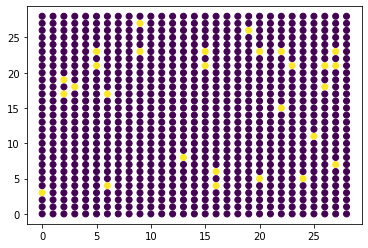

In [39]:
X,Y = np.meshgrid(np.arange(occlusion_order_adjacency_matrix.shape[1]), np.arange(occlusion_order_adjacency_matrix.shape[0]))
plt.scatter(X.flatten(), Y.flatten(), c=occlusion_order_adjacency_matrix.flatten())

plt.show()

Text(160.9, 0.5, 'Occluder')

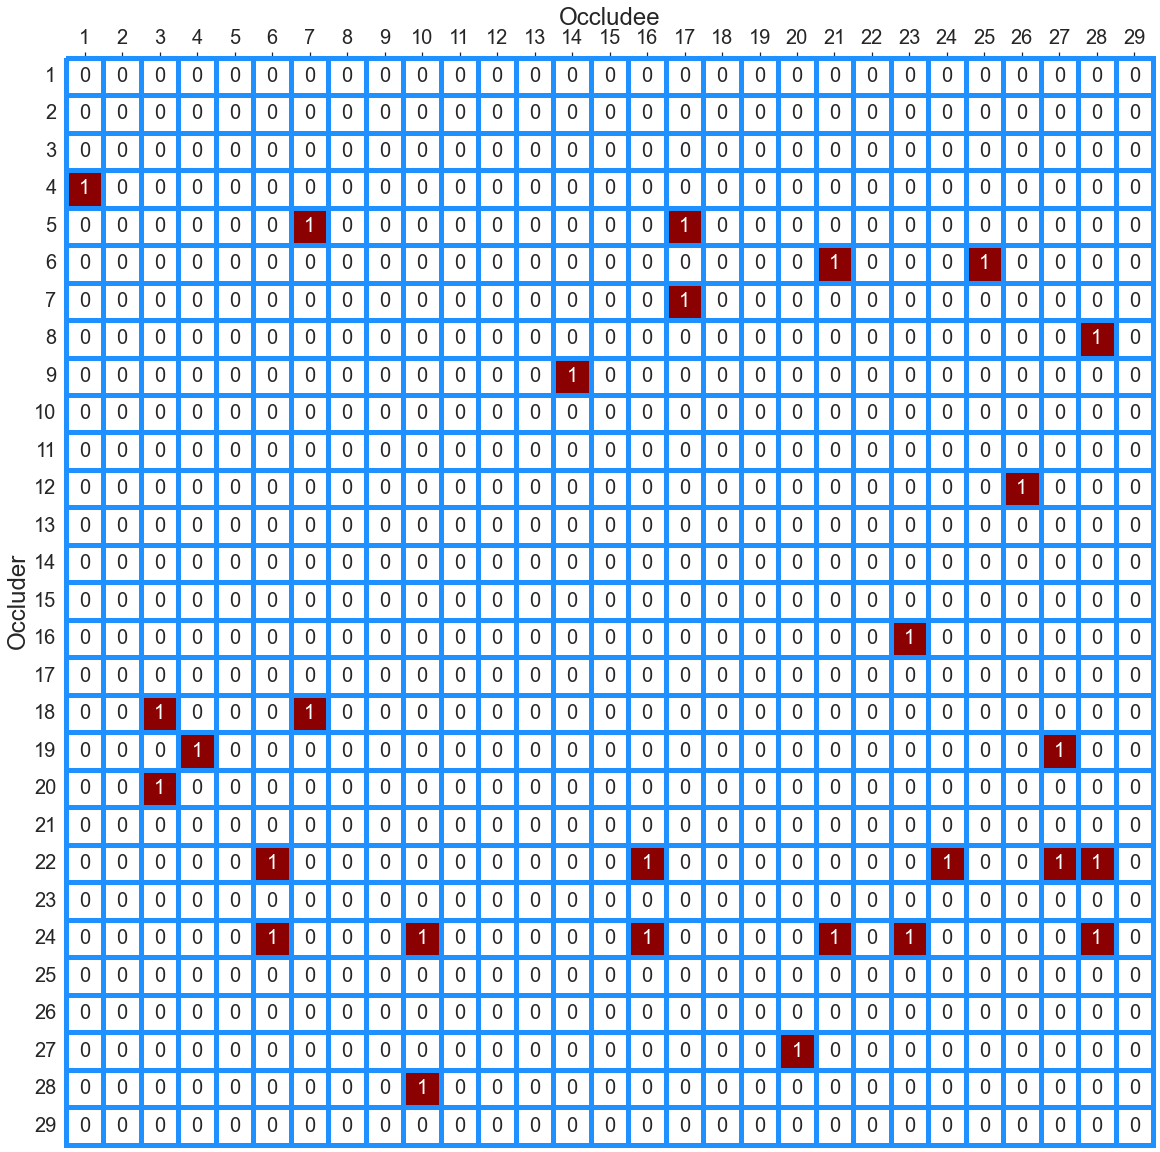

In [68]:

from matplotlib.colors import ListedColormap
import seaborn as sns
m = occlusion_order_adjacency_matrix.astype(int)
unique_chars, matrix = np.unique(m, return_inverse=True)
color_dict = {1: 'darkred', 0: 'white'}
plt.figure(figsize=(20,20))
sns.set(font_scale=2)
ax = sns.heatmap(matrix.reshape(m.shape), annot=m, annot_kws={'fontsize': 20}, fmt='',
                 linecolor='dodgerblue', lw=5, square=True, clip_on=False,
                 cmap=ListedColormap([color_dict[char] for char in unique_chars]),
                 xticklabels=np.arange(m.shape[1]) + 1, yticklabels=np.arange(m.shape[0]) + 1, cbar=False)
ax.tick_params(labelrotation=0)
# ax.tick_params(axis='x', bottom=False)
plt.tick_params(axis='both', which='major', labelsize=20, labelbottom = False, bottom=False, top = False, labeltop=True)
plt.xlabel("Occludee")
ax.xaxis.set_ticks_position('top')
ax.xaxis.set_label_position('top')
plt.ylabel("Occluder")

ValueError: The number of FixedLocator locations (28), usually from a call to set_ticks, does not match the number of ticklabels (29).

<Figure size 720x720 with 0 Axes>

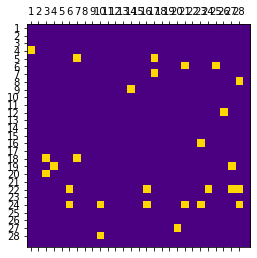

In [50]:
from matplotlib.colors import ListedColormap
m = occlusion_order_adjacency_matrix 
plt.figure(figsize=(10,10))
plt.matshow(m, cmap=ListedColormap(['indigo', 'gold']), extent=(0.5, len(m)+0.5, len(m)+0.5, 0.5))
# plt.xticks(range(1, len(m)+1))
# plt.yticks(range(1, len(m)+1))
# plt.tick_params(axis='x', bottom=False)
# # plt.grid(c='indigo', ls=':', lw='0.4')
# # plt.show()
# ax = plt.gca()

# # Major ticks
# ax.set_xticks(np.arange(1, len(m), 1))
# ax.set_yticks(np.arange(1, len(m), 1))

# # Labels for major ticks
# ax.set_xticklabels(np.arange(1, len(m)+1, 1))
# ax.set_yticklabels(np.arange(1, len(m)+1, 1))

# # Minor ticks
# ax.set_xticks(np.arange(-.5, len(m), 1), minor=True)
# ax.set_yticks(np.arange(-.5, len(m), 1), minor=True)

# # Gridlines based on minor ticks
# ax.grid(which='minor', color='w', linestyle='-', linewidth=2)

# # Remove minor ticks
# ax.tick_params(which='minor', bottom=False, left=False)

In [55]:
# import matplotlib.pyplot as plt
# import matplotlib.gridspec as gridspec

# fig = plt.figure(figsize=(10, 8))
# outer = gridspec.GridSpec(2, 2, wspace=0.2, hspace=0.2)

# for i in range(4):
#     inner = gridspec.GridSpecFromSubplotSpec(2, 1,
#                     subplot_spec=outer[i], wspace=0.1, hspace=0.1)

#     for j in range(2):
#         ax = plt.Subplot(fig, inner[j])
#         t = ax.text(0.5,0.5, 'outer=%d, inner=%d' % (i, j))
#         t.set_ha('center')
#         ax.set_xticks([])
#         ax.set_yticks([])
        
#         fig.add_subplot(ax)

# fig.show()

In [26]:
len(amodal_img_list)

24

/home/knowledge/.local/lib/python3.7/site-packages/ipykernel_launcher.py:47: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


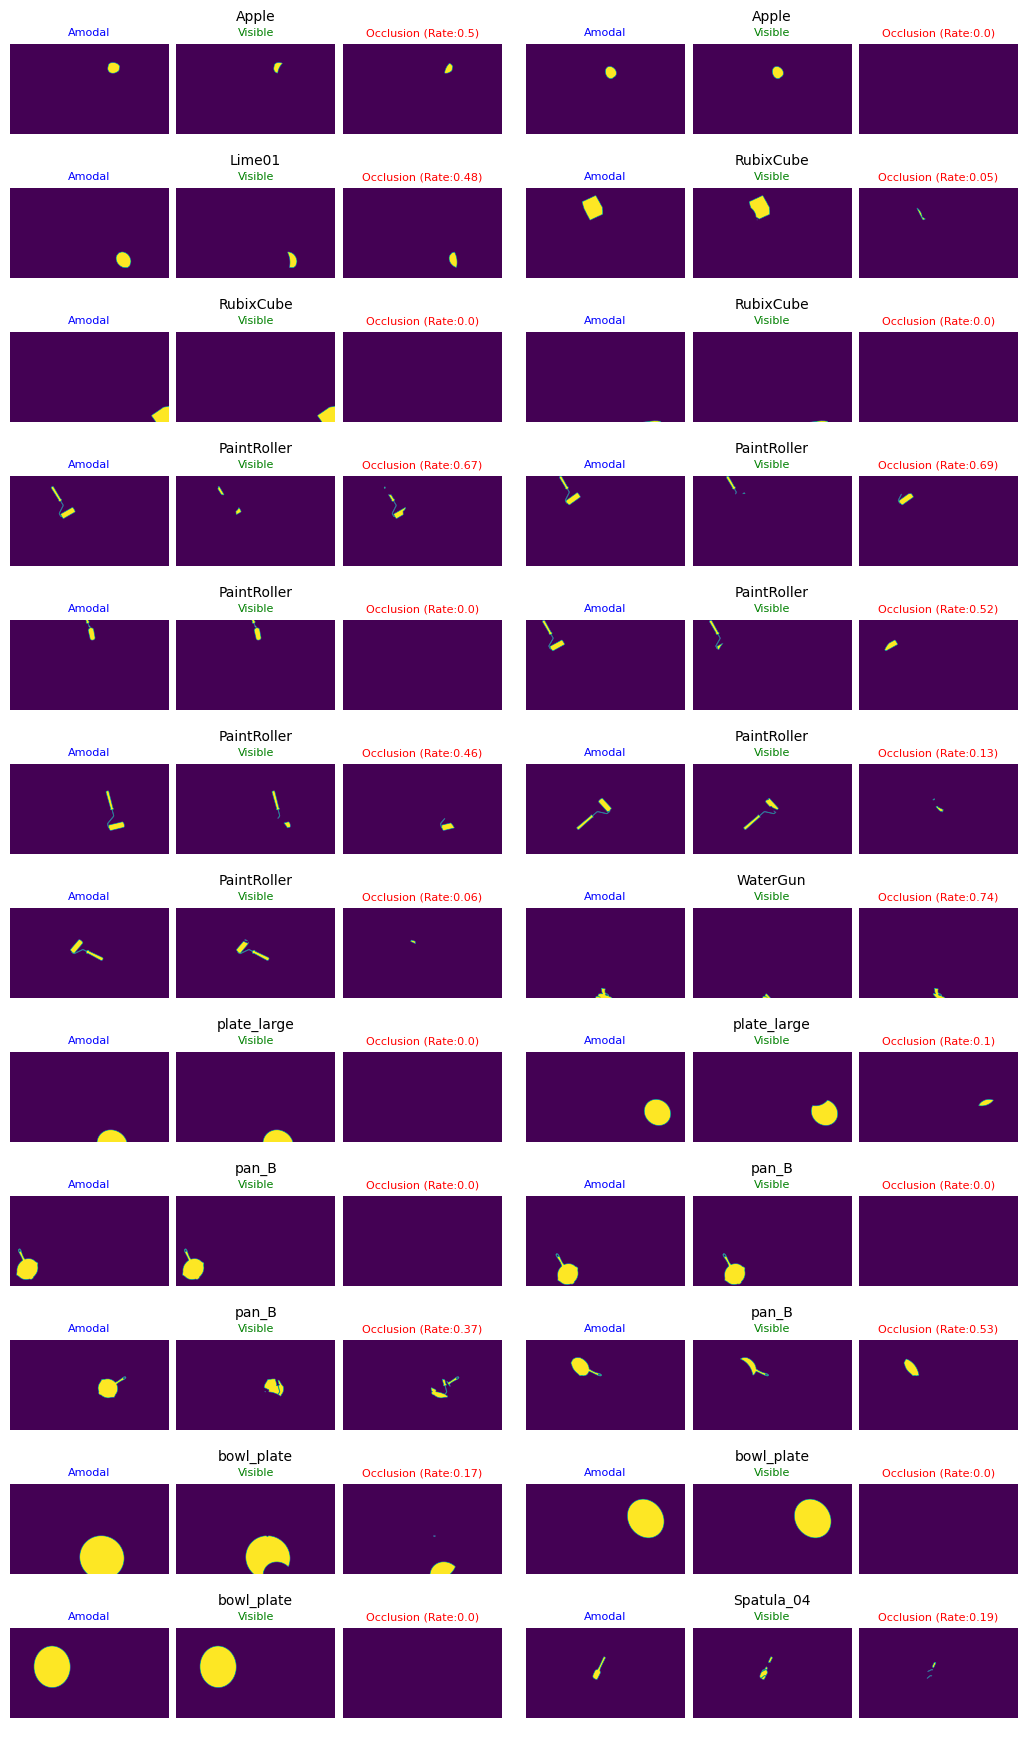

In [54]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(13, len(amodal_img_list)))
outer = gridspec.GridSpec(len(amodal_img_list)//2 +1, 2, wspace=0.05, hspace=0.2)

for i in range(len(amodal_img_list)):
    object_name = ann_dic["object_name"][i]
    occlusion_rate = ann_dic["occluded_rate"][i]
    inner = gridspec.GridSpecFromSubplotSpec(1, 3,
                    subplot_spec=outer[i], wspace=0.05 )#, wspace=0.1, hspace=0.1)
    # set outer titles
    ax = plt.Subplot(fig, outer[i])
    ax.set_title(object_name, y=1.0, fontsize=10)
    ax.axis('off')
    fig.add_subplot(ax)

    # retrieve masks
    amoMask = amodal_img_list[i]
    amodal_mask = mask_util.decode(amoMask)
    visMask = vis_img_list[i]
    vis_mask = mask_util.decode(visMask)
    occMask = occ_img_list[i]
    occ_mask = mask_util.decode(occMask)

    for j in range(3):
    
        ax = plt.Subplot(fig, inner[j])
        # t = ax.text(0.5,0.5, 'outer=%d, inner=%d' % (i, j))
        # t.set_ha('center')
        # ax.set_xticks([])
        # ax.set_yticks([])
        ax.axis('off')
        if j == 0:
            ax.imshow(amodal_mask)
            ax.set_title("Amodal", fontsize=8, color='blue')
        elif j == 1:
            ax.imshow(vis_mask)
            ax.set_title("Visible", fontsize=8, color='green')
        elif j == 2:
            ax.imshow(occ_mask)
            ax.set_title(f"Occlusion (Rate:{occlusion_rate})", fontsize=8, color='red')       
        fig.add_subplot(ax)

fig.suptitle("Object Masks Visualisation",y=1.0)
fig.show()

ValueError: num must be 1 <= num <= 75, not 86

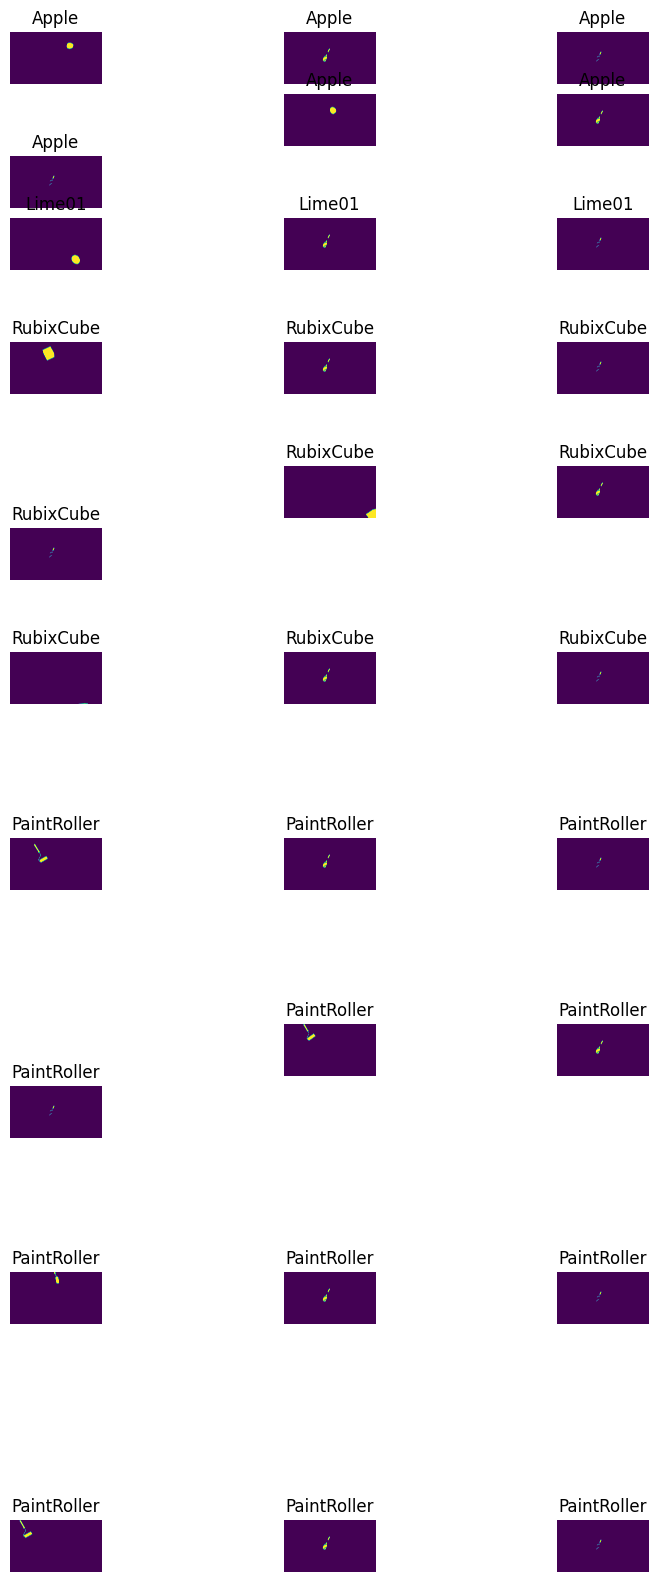

In [11]:
amodal_img_list = ann_dic["amodal"]
if len(amodal_img_list) > 0:
    cols = 3
    rows = len(amodal_img_list)*3 // cols + 1
    # print(len(amodal_img_list))
    # print(cols,rows)
    from matplotlib import pyplot as plt
    fig = plt.figure(figsize=(10,20))
    curr_index = 0
    for index, amoMask in enumerate(amodal_img_list):
        object_name = ann_dic["object_name"][index]
        amodal_mask = mask_util.decode(amoMask)
        vis_mask = vis_img_list[index]
        vis_mask = mask_util.decode(visMask)
        occ_mask = occ_img_list[index]
        occ_mask = mask_util.decode(occMask)
        index += curr_index

        plt.subplot(rows,cols, index+1)
        plt.axis('off')
        plt.title(object_name)
        plt.imshow(amodal_mask)

        plt.subplot(rows,cols, index+2)
        plt.axis('off')
        plt.title(object_name)
        plt.imshow(vis_mask)

        plt.subplot(rows,cols, index+3)
        plt.axis('off')
        plt.title(object_name)
        plt.imshow(occ_mask)

        curr_index = index + 3




    plt.tight_layout()
    # plt.suptitle(f"Amodal Masks for {id}.png")
    # plt.show()        
    # plt.savefig(f'{vis_dir_img}/amodal_masks_{id}.png')
    # plt.close()

## Visualize Annotations on RGB Images

In [79]:
img_dir_path = f"{output_dir}/visualize_occlusion_masks/"
img_list = sorted(os.listdir(img_dir_path), key=lambda x: float(x[4:-4]))

cols = 4
rows = len(img_list) //cols + 1
print(len(img_list))
print(cols,rows)

fig = plt.figure(figsize=(20,80))
for i in range(len(img_list)):
    img_filename = img_list[i]
    img_path = os.path.join(img_dir_path,img_filename)
    image = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # convert to RGB   
        
    plt.subplot(rows,cols, i+1)
    plt.axis('off')
    plt.title(img_filename)
    plt.imshow(image)

plt.tight_layout()
# plt.suptitle(f"Images in {img_dir_path}")
#plt.show()        
plt.savefig(f'/home/ngzhili/uoais/testing/visualize_uoais_sim/{ann_type}/occ_plot.png')
plt.close()

201
4 51


In [80]:

img_dir_path = f"{output_dir}/visualize_visible_masks/"
img_list = sorted(os.listdir(img_dir_path), key=lambda x: float(x[4:-4]))

cols = 4
rows = len(img_list) //cols + 1
print(len(img_list))
print(cols,rows)

fig = plt.figure(figsize=(20,80))
for i in range(len(img_list)):
    img_filename = img_list[i]
    img_path = os.path.join(img_dir_path,img_filename)
    image = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # convert to RGB      
        
    plt.subplot(rows,cols, i+1)
    plt.axis('off')
    plt.title(img_filename)
    plt.imshow(image)

plt.tight_layout()
# plt.suptitle(f"Images in {img_dir_path}")
#plt.show()       
plt.savefig(f'/home/ngzhili/uoais/testing/visualize_uoais_sim/{ann_type}/vis_plot.png') 
plt.close()

201
4 51
